<img src="https://www.cqf.com/themes/custom/creode/logo.svg" data-align="left" style="vertical-align: top; padding-top: 23px;" style="width:10.0%" alt="No description has been provided for this image" />
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg" data-align="right" style="vertical-align: middle;" style="width:12.0%" alt="No description has been provided for this image" />

# Quick Code for Tutorial

Backtesting for Analytical VaR. Cornish-Fisher VaR

**Experimental Python**

# Introduction<a href="#Introduction" class="anchor-link">¶</a>

-   This Python notebooks implements backtesting for Analytical VaR --
    test for the number of breaches

-   Please note other implementations of VaR backtesting and any exam
    tasks, <u>are likely to have variation</u>. For example, VaR formula
    can include an adjustment for \$\\mu - \\frac{1}{2} \\sigma T\$ even
    if \$\\mu = 0\$, and rolling window for \$\\sigma\$ computation
    might change.

-   There might be alternative requirements, such as EWMA volatility
    forecast \$\\sigma\_{t \| t-1}\$ might be requested prior to
    computing VaR based on it. Or a task might have additional
    requirements, such as computation and analysis of consequitive
    breaches.

**Firm-wide risk scenario:**

Imagine each day you calculate 99%/10D VaR from the available prior
data, and perform its backtest. 99% is confidence level, \$c\$ and so
\$1-c = 0.01\$. 10D stands for 10-day period.

Compute (a) the percentage of VaR breaches and (b) probability of breach
in VaR, given a breach was observed for the previous period.

The purpose of backtest is to check if the number of VaR breaches is
close to the theoretical 1%. That allows for 2.52 breaches
(statistically speaking) within a trading year.

Despite the simplicity of backtesting design, the aggregated firm-wide
risk typically evaluated by experienced risk managers.

**Rolling Window**

10-Day Value at Risk is computed on the rolling basis -- that is we use
a rolling window of 21-42 observations (log-returns) in order to compute
the standard deviation.

1.  We don't want the rolling window to be too short (eg to compute std
    dev from 10 or 15 returns), but equally do not wish to compute from
    60-100 returns which will make our Value at Risk too insensitive to
    recent volatility.

2.  Please remember that regardless of the number of observations, the
    timescale of standard deviation is always **DAILY**. In order to
    compute 10-day VaR, we scalee

\$\$ \\sigma\_{10D} = \\sqrt{\\sigma\_{1D}^2 + \\sigma\_{1D}^2 +
\\ldots} = \\sigma\_{1D}^2 \\sqrt{10}\$\$

With Factor (Normal Factor) being a percentile of the Normal
Distribution that \`cuts' 1% on the tail, we here use crudely simplified
formula,

\$\$VaR = Factor \\times \\sigma\_{10D} \$\$

**Data Loss**

Day 1 index level needed to compute the first 1D log-return.

21 log-returns (observations) are needed to compute the first std dev,
which would be of DAILY timescale.

For the last ten days of the dataset, we will have 10D VaR but no
information about the forward return.

The above makes the Number of eligible comparsons between 10D VaR and
10-day forward return to be less then the number of returns.

In \[ \]:

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    from scipy.stats import norm
    from scipy.optimize import fsolve # this is required for conversion of empirical skewness and kurtosis into S,K parameters for CF Approximation

In \[ \]:

    # We summarise all parameters

    rolling_window = 21  # here is 21 observations

    c = 0.99
    inverse_cdf = norm.ppf(1-c)

    factor = inverse_cdf 

    print(f'Exact value of ICDF of the normal distribution for p = {1-c} is: \033[1m{inverse_cdf}\033[0m')

    Exact value of ICDF of the normal distribution for p = 0.010000000000000009 is: -2.3263478740408408

### Load S&P 500 index levels, compute log-returns and std dev<a href="#Load-S&amp;P-500-index-levels,-compute-log-returns-and-std-dev" class="anchor-link">¶</a>

We refer to index values as *levels* as is customary in econometrics.

We also compute daily log-returns.

To remind, the sample standard deviation is computed on rolling basis,
and the window is shifted by 1 observation (return).

In \[ \]:

    # Read the Excel file
    data = pd.read_excel('SP500_VaR.xlsx', index_col='Date')

    # Ensure the 'Date' column is parsed as datetime type if it's not automatically recognized
    data.index = pd.to_datetime(data.index)

    # Verify the DataFrame structure
    # print(data.head())

                     S&P500  Unnamed: 2
    Date                               
    2013-01-22  1492.560059         NaN
    2013-01-23  1494.810059    0.001506
    2013-01-24  1494.819946    0.000007
    2013-01-25  1502.959961    0.005431
    2013-01-28  1500.180054   -0.001851

In \[ \]:

    data['LogReturn'] = np.log(data['S&P500']) - np.log(data['S&P500'].shift(1))
    #xl['Mean']  = xl['LogReturn'].rolling(21, min_periods=21).mean() 

    data['STD']  = data['LogReturn'].rolling(rolling_window, min_periods=rolling_window).std()

In \[ \]:

    data['VAR10D'] =  factor * (data['STD']) * np.sqrt(10)

    # Re-factored optimised code would do below -- or even precompute factor * np.sqrt(10), even though time scaling relates to STD DEV
    # data['VAR10D'] =  factor * np.sqrt(10) * (data['STD']) 


    data['Ret10D'] = np.log(data['S&P500'].shift(-10) / data['S&P500'] )

    # .shift(-10) brings up the future price (index level), which will realise in 10 days

    data['Breach'] = data['Ret10D'] <  data['VAR10D']

### Breaches in VaR<a href="#Breaches-in-VaR" class="anchor-link">¶</a>

Compare that 10D VaR number computed 'in the past' -- notionally ten
days ago -- to the realised return and check if your prediction about
the worst loss was breached. Hence, the backtesting.

\$\$ r\_{10D,t} \< VaR\_{t-10} \$\$

means breach, given both numbers are negative:

-   VaR is fixed at time t and compared to the return realised from
    \$t\$ to \$t + 10\$. A breach occurs when a realised 10-day return
    \$r\_{10D,t} = ln(S\_{t+10}/S_t)\$ is below.

-   Nbreaches divided by Ncomparisons gives the percentage of breaches.
    Identify the eligible number of observations (VaR values) and the
    number of breaches.

In \[ \]:

    print(data.to_string())
    #print(xl.to_string(columns=[0,1,7,9,10]))

                     S&P500  Unnamed: 2  LogReturn       STD    VAR10D    Ret10D  Breach
    Date                                                                                
    2013-01-22  1492.560059         NaN        NaN       NaN       NaN  0.012471   False
    2013-01-23  1494.810059    0.001506   0.001506       NaN       NaN  0.011513   False
    2013-01-24  1494.819946    0.000007   0.000007       NaN       NaN  0.009700   False
    2013-01-25  1502.959961    0.005431   0.005431       NaN       NaN  0.009911   False
    2013-01-28  1500.180054   -0.001851  -0.001851       NaN       NaN  0.011156   False
    2013-01-29  1507.839966    0.005093   0.005093       NaN       NaN  0.007657   False
    2013-01-30  1501.959961   -0.003907  -0.003907       NaN       NaN  0.012156   False
    2013-01-31  1498.109985   -0.002567  -0.002567       NaN       NaN  0.015414   False
    2013-02-01  1513.170044    0.010003   0.010003       NaN       NaN  0.004365   False
    2013-02-04  1495.709961   -0.011606  -0.011606       NaN       NaN  0.023281   False
    2013-02-05  1511.290039    0.010363   0.010363       NaN       NaN  0.000437   False
    2013-02-06  1512.119995    0.000549   0.000549       NaN       NaN -0.006435   False
    2013-02-07  1509.390015   -0.001807  -0.001807       NaN       NaN  0.004106   False
    2013-02-08  1517.930054    0.005642   0.005642       NaN       NaN -0.020015   False
    2013-02-11  1517.010010   -0.000606  -0.000606       NaN       NaN -0.013318   False
    2013-02-12  1519.430054    0.001594   0.001594       NaN       NaN -0.002267   False
    2013-02-13  1520.329956    0.000592   0.000592       NaN       NaN -0.003723   False
    2013-02-14  1521.380005    0.000690   0.000690       NaN       NaN -0.002092   False
    2013-02-15  1519.790039   -0.001046  -0.001046       NaN       NaN  0.003553   False
    2013-02-19  1530.939941    0.007310   0.007310       NaN       NaN  0.005764   False
    2013-02-20  1511.949951   -0.012482  -0.012482       NaN       NaN  0.019330   False
    2013-02-21  1502.420044   -0.006323  -0.006323  0.005969 -0.043908  0.027468   False
    2013-02-22  1515.599976    0.008734   0.008734  0.006243 -0.045926  0.023205   False
    2013-02-25  1487.849976   -0.018479  -0.018479  0.007513 -0.055272  0.044928   False
    2013-02-26  1496.939941    0.006091   0.006091  0.007540 -0.055465  0.036431   False
    2013-02-27  1515.989990    0.012646   0.012646  0.008028 -0.059057  0.025098   False
    2013-02-28  1514.680054   -0.000864  -0.000864  0.007962 -0.058575  0.031550   False
    2013-03-01  1518.199951    0.002321   0.002321  0.007917 -0.058241  0.027609   False
    2013-03-04  1525.199951    0.004600   0.004600  0.007932 -0.058353  0.017483   False
    2013-03-05  1539.790039    0.009521   0.009521  0.007905 -0.058153  0.005537   False
    2013-03-06  1541.459961    0.001084   0.001084  0.007374 -0.054246  0.011129   False
    2013-03-07  1544.260010    0.001815   0.001815  0.007087 -0.052134  0.000997   False
    2013-03-08  1551.180054    0.004471   0.004471  0.007125 -0.052416  0.003674   False
    2013-03-11  1556.219971    0.003244   0.003244  0.007103 -0.052255 -0.002915   False
    2013-03-12  1552.479980   -0.002406  -0.002406  0.007083 -0.052107  0.007246   False
    2013-03-13  1554.520020    0.001313   0.001313  0.007073 -0.052031  0.005344   False
    2013-03-14  1563.229980    0.005587   0.005587  0.007138 -0.052513  0.003805   False
    2013-03-15  1560.699951   -0.001620  -0.001620  0.007166 -0.052720  0.000942   False
    2013-03-18  1552.099976   -0.005526  -0.005526  0.007317 -0.053830  0.011626   False
    2013-03-19  1548.339966   -0.002425  -0.002425  0.007342 -0.054014  0.003449   False
    2013-03-20  1558.709961    0.006675   0.006675  0.007316 -0.053819  0.000814   False
    2013-03-21  1545.800049   -0.008317  -0.008317  0.006985 -0.051386  0.004827   False
    2013-03-22  1556.890015    0.007149   0.007149  0.006892 -0.050699  0.003962   False
    2013-03-25  1551.689941   -0.003346  -0.003346  0.006778 -0.049863  0.010845   False
    2013-03-26  1563.770020    0.007755   0.007755  0.005225 -0.038435  0.015206   False
    2013-03-27  1562.849976   -0.000589  -0.000589  0.005190 -0.038180  0.019340   False
    2013-03-28  1569.189941    0.004048   0.004048  0.004620 -0.033989  0.012451   False
    2013-04-01  1562.170044   -0.004484  -0.004484  0.004783 -0.035187 -0.006300   False
    2013-04-02  1570.250000    0.005159   0.005159  0.004848 -0.035665  0.002747   False
    2013-04-03  1553.689941   -0.010602  -0.010602  0.005473 -0.040264 -0.001082   False
    2013-04-04  1559.979980    0.004040   0.004040  0.005162 -0.037978 -0.011846   False
    2013-04-05  1553.280029   -0.004304  -0.004304  0.005271 -0.038777  0.001267   False
    2013-04-08  1563.069946    0.006283   0.006283  0.005421 -0.039877 -0.000365   False
    2013-04-09  1568.609985    0.003538   0.003538  0.005391 -0.039658  0.006463   False
    2013-04-10  1587.729980    0.012115   0.012115  0.005934 -0.043655 -0.005647   False
    2013-04-11  1593.369995    0.003546   0.003546  0.005908 -0.043460 -0.005166   False
    2013-04-12  1588.849976   -0.002841  -0.002841  0.005974 -0.043950 -0.004169   False
    2013-04-15  1552.359985   -0.023234  -0.023234  0.007883 -0.057992  0.026226   False
    2013-04-16  1574.569946    0.014206   0.014206  0.008487 -0.062436  0.014502   False
    2013-04-17  1552.010010   -0.014431  -0.014431  0.009006 -0.066251  0.019581   False
    2013-04-18  1541.609985   -0.006724  -0.006724  0.009112 -0.067031  0.035669   False
    2013-04-19  1555.250000    0.008809   0.008809  0.009204 -0.067708  0.037339   False
    2013-04-22  1562.500000    0.004651   0.004651  0.009059 -0.066645  0.034595   False
    2013-04-23  1578.780029    0.010365   0.010365  0.009203 -0.067703  0.029446   False
    2013-04-24  1578.790039    0.000006   0.000006  0.009159 -0.067379  0.033570   False
    2013-04-25  1585.160034    0.004027   0.004027  0.009054 -0.066603  0.025850   False
    2013-04-26  1582.239990   -0.001844  -0.001844  0.009066 -0.066696  0.032006   False
    2013-04-29  1593.609985    0.007160   0.007160  0.009151 -0.067317  0.024888   False
    2013-04-30  1597.569946    0.002482   0.002482  0.009078 -0.066783  0.032498   False
    2013-05-01  1582.699951   -0.009351  -0.009351  0.009300 -0.068419  0.046950   False
    2013-05-02  1597.589966    0.009364   0.009364  0.009141 -0.067248  0.032564   False
    2013-05-03  1614.420044    0.010480   0.010480  0.009343 -0.068729  0.032332   False
    2013-05-06  1617.500000    0.001906   0.001906  0.009243 -0.067997  0.029718   False
    2013-05-07  1625.959961    0.005217   0.005217  0.009221 -0.067833  0.026222   False
    2013-05-08  1632.689941    0.004131   0.004131  0.009227 -0.067879  0.013784   False
    2013-05-09  1626.670044   -0.003694  -0.003694  0.008994 -0.066168  0.014549   False
    2013-05-10  1633.699951    0.004312   0.004312  0.009006 -0.066255  0.009685   False
    2013-05-13  1633.770020    0.000043   0.000043  0.008964 -0.065941  0.015964   False
    2013-05-14  1650.339966    0.010091   0.010091  0.007168 -0.052730 -0.001200   False
    2013-05-15  1658.780029    0.005101   0.005101  0.006711 -0.049373 -0.002638   False
    2013-05-16  1650.469971   -0.005022  -0.005022  0.005775 -0.042482 -0.012026   False
    2013-05-17  1667.469971    0.010247   0.010247  0.005539 -0.040748 -0.016355   False
    2013-05-20  1666.290039   -0.000708  -0.000708  0.005492 -0.040405 -0.021173   False
    2013-05-21  1669.160034    0.001721   0.001721  0.005493 -0.040411 -0.036770   False
    2013-05-22  1655.349976   -0.008308  -0.008308  0.005770 -0.042449 -0.020007   False
    2013-05-23  1650.510010   -0.002928  -0.002928  0.005862 -0.043126 -0.004329   False
    2013-05-24  1649.599976   -0.000552  -0.000552  0.005873 -0.043203 -0.004125   False
    2013-05-28  1660.060059    0.006321   0.006321  0.005883 -0.043278 -0.020651   False
    2013-05-29  1648.359985   -0.007073  -0.007073  0.006109 -0.044940 -0.021983   False
    2013-05-30  1654.410034    0.003664   0.003664  0.006123 -0.045042 -0.010970   False
    2013-05-31  1630.739990   -0.014411  -0.014411  0.006654 -0.048953 -0.002462   False
    2013-06-03  1640.420044    0.005918   0.005918  0.006489 -0.047738 -0.000842   False
    2013-06-04  1631.380005   -0.005526  -0.005526  0.006289 -0.046265  0.012445   False
    2013-06-05  1608.900024   -0.013876  -0.013876  0.007013 -0.051595  0.012373   False
    2013-06-06  1622.560059    0.008454   0.008454  0.007174 -0.052772 -0.021410   False
    2013-06-07  1643.380005    0.012750   0.012750  0.007658 -0.056336 -0.031494   False
    2013-06-10  1642.810059   -0.000347  -0.000347  0.007605 -0.055947 -0.043366   False
    2013-06-11  1626.130005   -0.010205  -0.010205  0.007893 -0.058063 -0.023709   False
    2013-06-12  1612.520020   -0.008405  -0.008405  0.008091 -0.059524 -0.005759   False
    2013-06-13  1636.359985    0.014676   0.014676  0.008449 -0.062155 -0.014255   False
    2013-06-14  1626.729980   -0.005902  -0.005902  0.008432 -0.062027 -0.012651   False
    2013-06-17  1639.040039    0.007539   0.007539  0.008571 -0.063053 -0.014801   False
    2013-06-18  1651.810059    0.007761   0.007761  0.008434 -0.062043 -0.023107   False
    2013-06-19  1628.930054   -0.013948  -0.013948  0.008934 -0.065724 -0.008335   False
    2013-06-20  1588.189941   -0.025328  -0.025328  0.010348 -0.076126  0.027144   False
    2013-06-21  1592.430054    0.002666   0.002666  0.010310 -0.075847  0.029715   False
    2013-06-24  1573.089966   -0.012219  -0.012219  0.010555 -0.077651  0.049139   False
    2013-06-25  1588.030029    0.009452   0.009452  0.010859 -0.079885  0.039868   False
    2013-06-26  1603.260010    0.009545   0.009545  0.011002 -0.080934  0.043786   False
    2013-06-27  1613.199951    0.006181   0.006181  0.011055 -0.081330  0.040687   False
    2013-06-28  1606.280029   -0.004299  -0.004299  0.011023 -0.081091  0.046360   False
    2013-07-01  1614.959961    0.005389   0.005389  0.010697 -0.078693  0.037255   False
    2013-07-02  1614.079956   -0.000545  -0.000545  0.010597 -0.077955  0.040570   False
    2013-07-03  1615.410034    0.000824   0.000824  0.010545 -0.077573  0.044767   False
    2013-07-05  1631.890015    0.010150   0.010150  0.010318 -0.075907  0.036226   False
    2013-07-08  1640.459961    0.005238   0.005238  0.010220 -0.075187  0.033019   False
    2013-07-09  1652.319946    0.007204   0.007204  0.009957 -0.073249  0.023961   False
    2013-07-10  1652.619995    0.000182   0.000182  0.009956 -0.073242  0.019961   False
    2013-07-11  1675.020020    0.013463   0.013463  0.010049 -0.073922  0.009051   False
    2013-07-12  1680.189941    0.003082   0.003082  0.009797 -0.072072  0.006798   False
    2013-07-15  1682.500000    0.001374   0.001374  0.009354 -0.068810  0.001681   False
    2013-07-16  1676.260010   -0.003716  -0.003716  0.009281 -0.068276  0.005770   False
    2013-07-17  1680.910034    0.002770   0.002770  0.009182 -0.067546  0.002863   False
    2013-07-18  1689.369995    0.005020   0.005020  0.009103 -0.066967  0.010306   False
    2013-07-19  1692.089966    0.001609   0.001609  0.008428 -0.061998  0.010336   False
    2013-07-22  1695.530029    0.002031   0.002031  0.005694 -0.041885  0.006824   False
    2013-07-23  1692.390015   -0.001854  -0.001854  0.005796 -0.042637  0.002938   False
    2013-07-24  1685.939941   -0.003819  -0.003819  0.004925 -0.036228  0.002944   False
    2013-07-25  1690.250000    0.002553   0.002553  0.004719 -0.034718  0.004268   False
    2013-07-26  1691.650024    0.000828   0.000828  0.004490 -0.033031 -0.000136   False
    2013-07-29  1685.329956   -0.003743  -0.003743  0.004610 -0.033914  0.002453   False
    2013-07-30  1685.959961    0.000374   0.000374  0.004394 -0.032327  0.004852   False
    2013-07-31  1685.729980   -0.000136  -0.000136  0.004366 -0.032117 -0.000202   False
    2013-08-01  1706.869995    0.012463   0.012463  0.004874 -0.035852 -0.027049   False
    2013-08-02  1709.670044    0.001639   0.001639  0.004861 -0.035763 -0.031998   False
    2013-08-05  1707.140015   -0.001481  -0.001481  0.004627 -0.034040 -0.036435    True
    2013-08-06  1697.369995   -0.005739  -0.005739  0.004874 -0.035856 -0.026881   False
    2013-08-07  1690.910034   -0.003813  -0.003813  0.004836 -0.035577 -0.028865   False
    2013-08-08  1697.479980    0.003878   0.003878  0.004868 -0.035813 -0.024160   False
    2013-08-09  1691.420044   -0.003576  -0.003576  0.004094 -0.030115 -0.016645   False
    2013-08-12  1689.469971   -0.001154  -0.001154  0.004062 -0.029885 -0.019539   False
    2013-08-13  1694.160034    0.002772   0.002772  0.004093 -0.030110 -0.038313    True
    2013-08-14  1685.390015   -0.005190  -0.005190  0.004178 -0.030732 -0.030379   False
    2013-08-15  1661.319946   -0.014385  -0.014385  0.005211 -0.038337 -0.014033   False
    2013-08-16  1655.829956   -0.003310  -0.003310  0.005081 -0.037377 -0.013902   False
    2013-08-19  1646.060059   -0.005918  -0.005918  0.005156 -0.037929 -0.003829   False
    2013-08-20  1652.349976    0.003814   0.003814  0.005228 -0.038459  0.000442   False
    2013-08-21  1642.800049   -0.005796  -0.005796  0.005321 -0.039147  0.007447   False
    2013-08-22  1656.959961    0.008582   0.008582  0.005715 -0.042042 -0.001081   False
    2013-08-23  1663.500000    0.003939   0.003939  0.005764 -0.042401  0.004923   False
    2013-08-26  1656.780029   -0.004048  -0.004048  0.005795 -0.042629  0.016290   False
    2013-08-27  1630.479980   -0.016002  -0.016002  0.006641 -0.048857  0.035339   False
    2013-08-28  1634.959961    0.002744   0.002744  0.006696 -0.049259  0.029209   False
    2013-08-29  1638.170044    0.001961   0.001961  0.006732 -0.049527  0.029959   False
    2013-08-30  1632.969971   -0.003179  -0.003179  0.005946 -0.043739  0.038815   False
    2013-09-03  1639.770020    0.004156   0.004156  0.006049 -0.044502  0.038868   False
    2013-09-04  1653.079956    0.008084   0.008084  0.006437 -0.047354  0.042888   False
    2013-09-05  1655.079956    0.001209   0.001209  0.006388 -0.046996  0.039834   False
    2013-09-06  1655.170044    0.000054   0.000054  0.006365 -0.046825  0.032537   False
    2013-09-09  1671.709961    0.009943   0.009943  0.006726 -0.049478  0.017863   False
    2013-09-10  1683.989990    0.007319   0.007319  0.006913 -0.050853  0.007944   False
    2013-09-11  1689.130005    0.003048   0.003048  0.006945 -0.051089  0.002153   False
    2013-09-12  1683.420044   -0.003386  -0.003386  0.006951 -0.051138  0.009018   False
    2013-09-13  1687.989990    0.002711   0.002711  0.006887 -0.050665  0.002225   False
    2013-09-16  1697.599976    0.005677   0.005677  0.006131 -0.045105 -0.009499   False
    2013-09-17  1704.760010    0.004209   0.004209  0.006085 -0.044762 -0.005742   False
    2013-09-18  1725.520020    0.012104   0.012104  0.006271 -0.046132 -0.018513   False
    2013-09-19  1722.339966   -0.001845  -0.001845  0.006321 -0.046504 -0.025688   False
    2013-09-20  1709.910034   -0.007243  -0.007243  0.006418 -0.047211 -0.011416   False
    2013-09-23  1701.839966   -0.004731  -0.004731  0.006383 -0.046954 -0.015228   False
    2013-09-24  1697.420044   -0.002601  -0.002601  0.006405 -0.047122 -0.025037   False
    2013-09-25  1692.770020   -0.002743  -0.002743  0.006361 -0.046792 -0.021720   False
    2013-09-26  1698.670044    0.003479   0.003479  0.005036 -0.037049 -0.003603   False
    2013-09-27  1691.750000   -0.004082  -0.004082  0.005200 -0.038255  0.006745   False
    2013-09-30  1681.550049   -0.006047  -0.006047  0.005461 -0.040177  0.016859   False
    2013-10-01  1695.000000    0.007967   0.007967  0.005551 -0.040835  0.001804   False
    2013-10-02  1693.869995   -0.000667  -0.000667  0.005547 -0.040808  0.016203   False
    2013-10-03  1678.660034   -0.009020  -0.009020  0.005790 -0.042591  0.031945   False
    2013-10-04  1690.500000    0.007028   0.007028  0.005951 -0.043776  0.031444   False
    2013-10-07  1676.119995   -0.008543  -0.008543  0.006305 -0.046381  0.040078   False
    2013-10-08  1655.449951   -0.012409  -0.012409  0.006531 -0.048046  0.058208   False
    2013-10-09  1656.400024    0.000574   0.000574  0.006290 -0.046276  0.052898   False
    2013-10-10  1692.560059    0.021596   0.021596  0.007941 -0.058420  0.034556   False
    2013-10-11  1703.199951    0.006267   0.006267  0.008009 -0.058916  0.032674   False
    2013-10-14  1710.140015    0.004066   0.004066  0.008032 -0.059090  0.029937   False
    2013-10-15  1698.060059   -0.007089  -0.007089  0.008113 -0.059685  0.042594   False
    2013-10-16  1721.540039    0.013733   0.013733  0.008610 -0.063343  0.023973   False
    2013-10-17  1733.150024    0.006721   0.006721  0.008322 -0.061221  0.013405   False
    2013-10-18  1744.500000    0.006527   0.006527  0.008419 -0.061932  0.009777   False
    2013-10-21  1744.660034    0.000092   0.000092  0.008226 -0.060519  0.013250   False
    2013-10-22  1754.670044    0.005721   0.005721  0.008181 -0.060185  0.004719   False
    2013-10-23  1746.380005   -0.004736  -0.004736  0.008247 -0.060670  0.013711   False
    2013-10-24  1752.069946    0.003253   0.003253  0.008202 -0.060337 -0.002812   False
    2013-10-25  1759.770020    0.004385   0.004385  0.008214 -0.060429  0.006141   False
    2013-10-28  1762.109985    0.001329   0.001329  0.008109 -0.059652  0.005535   False
    2013-10-29  1771.949951    0.005569   0.005569  0.007931 -0.058343 -0.002407   False
    2013-10-30  1763.310059   -0.004888  -0.004888  0.007983 -0.058728  0.010544   False
    2013-10-31  1756.540039   -0.003847  -0.003847  0.008064 -0.059320  0.019216   False
    2013-11-01  1761.640015    0.002899   0.002899  0.007679 -0.056494  0.020530   False
    2013-11-04  1767.930054    0.003564   0.003564  0.007610 -0.055981  0.013261   False
    2013-11-05  1762.969971   -0.002810  -0.002810  0.007304 -0.053734  0.014025   False
    2013-11-06  1770.489990    0.004256   0.004256  0.006472 -0.047612  0.006126   False
    2013-11-07  1747.150024   -0.013270  -0.013270  0.007393 -0.054384  0.027493   False
    2013-11-08  1770.609985    0.013338   0.013338  0.006493 -0.047767  0.019104   False
    2013-11-11  1771.890015    0.000723   0.000723  0.006430 -0.047300  0.017117   False
    2013-11-12  1767.689941   -0.002373  -0.002373  0.006474 -0.047624  0.019640   False
    2013-11-13  1782.000000    0.008063   0.008063  0.006302 -0.046359  0.014059   False
    2013-11-14  1790.619995    0.004826   0.004826  0.005771 -0.042455  0.008447   False
    2013-11-15  1798.180054    0.004213   0.004213  0.005691 -0.041867  0.001511   False
    2013-11-18  1791.530029   -0.003705  -0.003705  0.005700 -0.041932  0.002019   False
    2013-11-19  1787.869995   -0.002045  -0.002045  0.005741 -0.042234  0.002759   False
    2013-11-20  1781.369995   -0.003642  -0.003642  0.005733 -0.042175  0.002053   False
    2013-11-21  1795.849976    0.008096   0.008096  0.005806 -0.042711  0.005132   False
    2013-11-22  1804.760010    0.004949   0.004949  0.005846 -0.043004  0.001998   False
    2013-11-25  1802.479980   -0.001264  -0.001264  0.005832 -0.042903  0.000078   False
    2013-11-26  1802.750000    0.000150   0.000150  0.005836 -0.042931 -0.011454   False
    2013-11-27  1807.229980    0.002482   0.002482  0.005755 -0.042340 -0.017713   False
    2013-11-29  1805.810059   -0.000786  -0.000786  0.005616 -0.041312 -0.017029   False
    2013-12-02  1800.900024   -0.002723  -0.002723  0.005571 -0.040984 -0.008006   False
    2013-12-03  1795.150024   -0.003198  -0.003198  0.005636 -0.041461 -0.007914   False
    2013-12-04  1792.810059   -0.001304  -0.001304  0.005621 -0.041350  0.009902   False
    2013-12-05  1785.030029   -0.004349  -0.004349  0.005678 -0.041772  0.013671   False
    2013-12-06  1805.089966    0.011175   0.011175  0.006087 -0.044782  0.007303   False
    2013-12-09  1808.369995    0.001815   0.001815  0.005146 -0.037858  0.010791   False
    2013-12-10  1802.619995   -0.003185  -0.003185  0.004489 -0.033027  0.016887   False
    2013-12-11  1782.219971   -0.011381  -0.011381  0.005224 -0.038430  0.033003   False
    2013-12-12  1775.500000   -0.003778  -0.003778  0.005268 -0.038757  0.036444   False
    2013-12-13  1775.319946   -0.000101  -0.000101  0.004952 -0.036427  0.036366   False
    2013-12-16  1786.540039    0.006300   0.006300  0.005036 -0.037047  0.034018   False
    2013-12-17  1781.000000   -0.003106  -0.003106  0.004975 -0.036597  0.028222   False
    2013-12-18  1810.650024    0.016511   0.016511  0.006135 -0.045135  0.011378   False
    2013-12-19  1809.599976   -0.000580  -0.000580  0.006113 -0.044972  0.009444   False
    2013-12-20  1818.319946    0.004807   0.004807  0.006100 -0.044874  0.010700   False
    2013-12-23  1827.989990    0.005304   0.005304  0.005966 -0.043888  0.005184   False
    2013-12-24  1833.319946    0.002912   0.002912  0.005912 -0.043493  0.002620   False
    2013-12-26  1842.020020    0.004734   0.004734  0.005955 -0.043807  0.000190   False
    2013-12-27  1841.400024   -0.000337  -0.000337  0.005959 -0.043840 -0.012129   False
    2013-12-30  1841.069946   -0.000179  -0.000179  0.005955 -0.043807 -0.001190   False
    2013-12-31  1848.359985    0.003952   0.003952  0.005978 -0.043978  0.000011   False
    2014-01-02  1831.979980   -0.008901  -0.008901  0.006318 -0.046482  0.007564   False
    2014-01-03  1831.369995   -0.000333  -0.000333  0.006258 -0.046038  0.003994   False
    2014-01-06  1826.770020   -0.002515  -0.002515  0.006285 -0.046239  0.009279   False
    2014-01-07  1837.880005    0.006063   0.006063  0.006262 -0.046066  0.003791   False
    2014-01-08  1837.489990   -0.000212  -0.000212  0.005852 -0.043048 -0.004926   False
    2014-01-09  1838.130005    0.000348   0.000348  0.005848 -0.043023 -0.026371   False
    2014-01-10  1842.369995    0.002304   0.002304  0.005785 -0.042555 -0.033563   False
    2014-01-13  1819.199951   -0.012656  -0.012656  0.005926 -0.043598 -0.014786   False
    2014-01-14  1838.880005    0.010760   0.010760  0.006187 -0.045512 -0.035807   False
    2014-01-15  1848.380005    0.005153   0.005153  0.006217 -0.045739 -0.029756   False
    2014-01-16  1845.890015   -0.001348  -0.001348  0.006172 -0.045404 -0.034894   False
    2014-01-17  1838.699951   -0.003903  -0.003903  0.006204 -0.045643 -0.054088    True
    2014-01-21  1843.800049    0.002770   0.002770  0.005185 -0.038144 -0.049246    True
    2014-01-22  1844.859985    0.000575   0.000575  0.005175 -0.038071 -0.051851    True
    2014-01-23  1828.459961   -0.008929  -0.008929  0.005516 -0.040578 -0.030559   False
    2014-01-24  1790.290039   -0.021096  -0.021096  0.007093 -0.052180  0.003752   False
    2014-01-27  1781.560059   -0.004888  -0.004888  0.007083 -0.052104  0.010208   False
    2014-01-28  1792.500000    0.006122   0.006122  0.007149 -0.052588  0.015088   False
    2014-01-29  1774.199951   -0.010262  -0.010262  0.007405 -0.054477  0.025080   False
    2014-01-30  1794.189941    0.011204   0.011204  0.007926 -0.058307  0.019669   False
    2014-01-31  1782.589966   -0.006486  -0.006486  0.007912 -0.058206  0.030953   False
    2014-02-03  1741.890015   -0.023097  -0.023097  0.009077 -0.066772  0.055208   False
    2014-02-04  1755.199951    0.007612   0.007612  0.009329 -0.068630  0.041050   False
    2014-02-05  1751.640015   -0.002030  -0.002030  0.009328 -0.068625  0.049094   False
    2014-02-06  1773.430054    0.012363   0.012363  0.009695 -0.071320  0.034810   False
    2014-02-07  1797.020020    0.013214   0.013214  0.010226 -0.075228  0.027763   False
    2014-02-10  1799.839966    0.001568   0.001568  0.010238 -0.075315  0.024847   False
    2014-02-11  1819.750000    0.011001   0.011001  0.010549 -0.077608  0.013867   False
    2014-02-12  1819.260010   -0.000269  -0.000269  0.010181 -0.074896  0.019072   False
    2014-02-13  1829.829956    0.005793   0.005793  0.009974 -0.073374  0.016058   False
    2014-02-14  1838.630005    0.004798   0.004798  0.009965 -0.073306  0.003854   False
    2014-02-18  1840.760010    0.001158   0.001158  0.009966 -0.073315  0.017849   False
    2014-02-19  1828.750000   -0.006546  -0.006546  0.010032 -0.073804  0.024341   False
    2014-02-20  1839.780029    0.006013   0.006013  0.010106 -0.074346  0.020045   False
    2014-02-21  1836.250000   -0.001921  -0.001921  0.010112 -0.074392  0.022503   False
    2014-02-24  1847.609985    0.006167   0.006167  0.009998 -0.073554  0.015872   False
    2014-02-25  1845.119995   -0.001349  -0.001349  0.008712 -0.064090  0.012126   False
    2014-02-26  1845.160034    0.000022   0.000022  0.008599 -0.063258  0.012409   False
    2014-02-27  1854.290039    0.004936   0.004936  0.008572 -0.063060 -0.004297   False
    2014-02-28  1859.449951    0.002779   0.002779  0.008130 -0.059806 -0.009901   False
    2014-03-03  1845.729980   -0.007406  -0.007406  0.008117 -0.059716  0.007072   False
    2014-03-04  1873.910034    0.015152   0.015152  0.008440 -0.062090 -0.000886   False
    2014-03-05  1873.810059   -0.000053  -0.000053  0.006149 -0.045238 -0.006983   False
    2014-03-06  1877.030029    0.001717   0.001717  0.006085 -0.044768 -0.002678   False
    2014-03-07  1878.040039    0.000538   0.000538  0.006000 -0.044142 -0.006153   False
    2014-03-10  1877.170044   -0.000463  -0.000463  0.005678 -0.041768 -0.010566   False
    2014-03-11  1867.630005   -0.005095  -0.005095  0.005382 -0.039590 -0.001077   False
    2014-03-12  1868.199951    0.000305   0.000305  0.005392 -0.039665 -0.008407   False
    2014-03-13  1846.339966   -0.011770  -0.011770  0.005723 -0.042103  0.001461   False
    2014-03-14  1841.130005   -0.002826  -0.002826  0.005772 -0.042459  0.008917   False
    2014-03-17  1858.829956    0.009568   0.009568  0.005997 -0.044116  0.007242   False
    2014-03-18  1872.250000    0.007194   0.007194  0.006100 -0.044872  0.007063   False
    2014-03-19  1860.770020   -0.006151  -0.006151  0.006288 -0.046255  0.016063   False
    2014-03-20  1872.010010    0.006022   0.006022  0.006179 -0.045457  0.008913   False
    2014-03-21  1866.520020   -0.002937  -0.002937  0.006133 -0.045115 -0.000766   False
    2014-03-24  1857.439941   -0.004877  -0.004877  0.006229 -0.045822 -0.006698   False
    2014-03-25  1865.619995    0.004394   0.004394  0.006160 -0.045319 -0.007349   False
    2014-03-26  1852.560059   -0.007025  -0.007025  0.006365 -0.046824  0.010535   False
    2014-03-27  1849.040039   -0.001902  -0.001902  0.006381 -0.046944 -0.008669   False
    2014-03-28  1857.619995    0.004629   0.004629  0.006370 -0.046861 -0.022831   False
    2014-03-31  1872.339966    0.007893   0.007893  0.006573 -0.048352 -0.022540   False
    2014-04-01  1885.520020    0.007015   0.007015  0.006477 -0.047647 -0.022820   False
    2014-04-02  1890.900024    0.002849   0.002849  0.005636 -0.041461 -0.015235   False
    2014-04-03  1888.770020   -0.001127  -0.001127  0.005645 -0.041531 -0.012745   False
    2014-04-04  1865.089966   -0.012617  -0.012617  0.006304 -0.046373  0.003639   False
    2014-04-07  1845.040039   -0.010808  -0.010808  0.006702 -0.049300  0.018531   False
    2014-04-08  1851.959961    0.003744   0.003744  0.006776 -0.049848  0.012572   False
    2014-04-09  1872.180054    0.010859   0.010859  0.007137 -0.052502  0.003429   False
    2014-04-10  1833.079956   -0.021106  -0.021106  0.008506 -0.062577  0.016405   False
    2014-04-11  1815.689941   -0.009532  -0.009532  0.008376 -0.061622  0.029168   False
    2014-04-14  1830.609985    0.008184   0.008184  0.008585 -0.063156  0.025734   False
    2014-04-15  1842.979980    0.006735   0.006735  0.008444 -0.062117  0.021987   False
    2014-04-16  1862.310059    0.010434   0.010434  0.008617 -0.063395  0.011410   False
    2014-04-17  1864.849976    0.001363   0.001363  0.008516 -0.062646  0.008697   False
    2014-04-21  1871.890015    0.003768   0.003768  0.008451 -0.062173  0.006799   False
    2014-04-22  1879.550049    0.004084   0.004084  0.008468 -0.062298 -0.006314   False
    2014-04-23  1875.390015   -0.002216  -0.002216  0.008406 -0.061841  0.001503   False
    2014-04-24  1878.609985    0.001715   0.001715  0.008364 -0.061528 -0.001588   False
    2014-04-25  1863.400024   -0.008129  -0.008129  0.008416 -0.061910  0.008060   False
    2014-04-28  1869.430054    0.003231   0.003231  0.008424 -0.061969  0.014456   False
    2014-04-29  1878.329956    0.004749   0.004749  0.008427 -0.061991  0.010128   False
    2014-04-30  1883.949951    0.002988   0.002988  0.008279 -0.060904  0.002428   False
    2014-05-01  1883.680054   -0.000143  -0.000143  0.008134 -0.059842 -0.006834   False
    2014-05-02  1881.140015   -0.001349  -0.001349  0.008111 -0.059671 -0.001745   False
    2014-05-05  1884.660034    0.001869   0.001869  0.008121 -0.059746  0.000223   False
    2014-05-06  1867.719971   -0.009029  -0.009029  0.007879 -0.057964  0.002732   False
    2014-05-07  1878.209961    0.005601   0.005601  0.007554 -0.055569  0.005215   False
    2014-05-08  1875.630005   -0.001375  -0.001375  0.007538 -0.055455  0.008949   False
    2014-05-09  1878.479980    0.001518   0.001518  0.007169 -0.052742  0.011670   False
    2014-05-12  1896.650024    0.009626   0.009626  0.005570 -0.040972  0.008014   False
    2014-05-13  1897.449951    0.000422   0.000422  0.004963 -0.036512  0.006477   False
    2014-05-14  1888.530029   -0.004712  -0.004712  0.004970 -0.036564  0.016542   False
    2014-05-15  1870.849976   -0.009406  -0.009406  0.005351 -0.039365  0.027790   False
    2014-05-16  1877.859985    0.003740   0.003740  0.004926 -0.036235  0.024778   False
    2014-05-19  1885.079956    0.003837   0.003837  0.004979 -0.036630  0.020561   False
    2014-05-20  1872.829956   -0.006520  -0.006520  0.005146 -0.037859  0.028970   False
    2014-05-21  1888.030029    0.008083   0.008083  0.005373 -0.039527  0.027391   False
    2014-05-22  1892.489990    0.002359   0.002359  0.005362 -0.039448  0.029649   False
    2014-05-23  1900.530029    0.004239   0.004239  0.005421 -0.039876  0.026348   False
    2014-05-27  1911.910034    0.005970   0.005970  0.005158 -0.037947  0.020132   False
    2014-05-28  1909.780029   -0.001115  -0.001115  0.005161 -0.037966  0.017703   False
    2014-05-29  1920.030029    0.005353   0.005353  0.005184 -0.038139  0.005236   False
    2014-05-30  1923.569946    0.001842   0.001842  0.005169 -0.038025  0.006524   False
    2014-06-02  1924.969971    0.000728   0.000728  0.005163 -0.037980  0.006633   False
    2014-06-03  1924.239990   -0.000379  -0.000379  0.005145 -0.037847  0.009182   False
    2014-06-04  1927.880005    0.001890   0.001890  0.005145 -0.037849  0.014982   False
    2014-06-05  1940.459961    0.006504   0.006504  0.004718 -0.034706  0.009754   False
    2014-06-06  1949.439941    0.004617   0.004617  0.004683 -0.034451  0.006866   False
    2014-06-09  1951.270020    0.000938   0.000938  0.004632 -0.034078  0.005795   False
    2014-06-10  1950.790039   -0.000246  -0.000246  0.004655 -0.034246 -0.000415   False
    2014-06-11  1943.890015   -0.003543  -0.003543  0.004430 -0.032586  0.008014   False
    2014-06-12  1930.109985   -0.007114  -0.007114  0.004784 -0.035196  0.013948   False
    2014-06-13  1936.160034    0.003130   0.003130  0.004635 -0.034100  0.012727   False
    2014-06-16  1937.780029    0.000836   0.000836  0.003954 -0.029087  0.011519   False
    2014-06-17  1941.989990    0.002170   0.002170  0.003928 -0.028893  0.016004   False
    2014-06-18  1956.979980    0.007689   0.007689  0.004122 -0.030327  0.008974   False
    2014-06-19  1959.479980    0.001277   0.001277  0.003663 -0.026946  0.013161   False
    2014-06-20  1962.869995    0.001729   0.001729  0.003402 -0.025025  0.007502   False
    2014-06-23  1962.609985   -0.000132  -0.000132  0.003426 -0.025207  0.000560   False
    2014-06-24  1949.979980   -0.006456  -0.006456  0.003809 -0.028019  0.011650   False
    2014-06-25  1959.530029    0.004886   0.004886  0.003748 -0.027572  0.002625   False
    2014-06-26  1957.219971   -0.001180  -0.001180  0.003750 -0.027587  0.005274   False
    2014-06-27  1960.959961    0.001909   0.001909  0.003631 -0.026714  0.008197   False
    2014-06-30  1960.229980   -0.000372  -0.000372  0.003638 -0.026763  0.006635   False
    2014-07-01  1973.319946    0.006656   0.006656  0.003848 -0.028307  0.004172   False
    2014-07-02  1974.619995    0.000659   0.000659  0.003833 -0.028201 -0.008391   False
    2014-07-03  1985.439941    0.005465   0.005465  0.003942 -0.029000 -0.003643   False
    2014-07-07  1977.650024   -0.003931  -0.003931  0.003924 -0.028869 -0.002035   False
    2014-07-08  1963.709961   -0.007074  -0.007074  0.004191 -0.030834  0.010043   False
    2014-07-09  1972.829956    0.004634   0.004634  0.004294 -0.031587  0.007162   False
    2014-07-10  1964.680054   -0.004140  -0.004140  0.004411 -0.032450  0.011790   False
    2014-07-11  1967.569946    0.001470   0.001470  0.004325 -0.031820  0.005459   False
    2014-07-14  1977.099976    0.004832   0.004832  0.004039 -0.029716  0.000915   False
    2014-07-15  1973.280029   -0.001934  -0.001934  0.004066 -0.029912 -0.001689   False
    2014-07-16  1981.569946    0.004192   0.004192  0.004129 -0.030373 -0.005820   False
    2014-07-17  1958.119995   -0.011905  -0.011905  0.004992 -0.036726 -0.014118   False
    2014-07-18  1978.219971    0.010213   0.010213  0.005203 -0.038273 -0.027194   False
    2014-07-21  1973.630005   -0.002323  -0.002323  0.005235 -0.038515 -0.017707   False
    2014-07-22  1983.530029    0.005004   0.005004  0.005327 -0.039187 -0.032444   False
    2014-07-23  1987.010010    0.001753   0.001753  0.005331 -0.039221 -0.034181   False
    2014-07-24  1987.979980    0.000488   0.000488  0.005082 -0.037388 -0.040241    True
    2014-07-25  1978.339966   -0.004861  -0.004861  0.005147 -0.037861 -0.023915   False
    2014-07-28  1978.910034    0.000288   0.000288  0.005133 -0.037762 -0.021447   False
    2014-07-29  1969.949951   -0.004538  -0.004538  0.005238 -0.038533 -0.018547   False
    2014-07-30  1970.069946    0.000061   0.000061  0.005236 -0.038522 -0.011923   False
    2014-07-31  1930.670044   -0.020202  -0.020202  0.006673 -0.049093  0.012615   False
    2014-08-01  1925.150024   -0.002863  -0.002863  0.006673 -0.049089  0.015417   False
    2014-08-04  1938.989990    0.007163   0.007163  0.006767 -0.049784  0.016749   False
    2014-08-05  1920.209961   -0.009733  -0.009733  0.007002 -0.051510  0.031470   False
    2014-08-06  1920.239990    0.000016   0.000016  0.006885 -0.050648  0.033929   False
    2014-08-07  1909.569946   -0.005572  -0.005572  0.006822 -0.050188  0.042447   False
    2014-08-08  1931.589966    0.011465   0.011465  0.007355 -0.054110  0.028987   False
    2014-08-11  1936.920044    0.002756   0.002756  0.007381 -0.054295  0.031008   False
    2014-08-12  1933.750000   -0.001638  -0.001638  0.007270 -0.053484  0.033696   False
    2014-08-13  1946.719971    0.006685   0.006685  0.007459 -0.054872  0.027061   False
    2014-08-14  1955.180054    0.004336   0.004336  0.007464 -0.054907  0.021034   False
    2014-08-15  1955.060059   -0.000061  -0.000061  0.007003 -0.051519  0.024410   False
    2014-08-18  1971.739990    0.008495   0.008495  0.006886 -0.050657  0.015370   False
    2014-08-19  1981.599976    0.004988   0.004988  0.006955 -0.051168  0.009603   False
    2014-08-20  1986.510010    0.002475   0.002475  0.006890 -0.050683  0.005592   False
    2014-08-21  1992.369995    0.002946   0.002946  0.006909 -0.050827  0.007670   False
    2014-08-22  1988.400024   -0.001995  -0.001995  0.006924 -0.050935  0.006587   False
    2014-08-25  1997.920044    0.004776   0.004776  0.006904 -0.050791 -0.004756   False
    2014-08-26  2000.020020    0.001051   0.001051  0.006905 -0.050798 -0.002167   False
    2014-08-27  2000.119995    0.000050   0.000050  0.006810 -0.050095 -0.001336   False
    2014-08-28  1996.739990   -0.001691  -0.001691  0.006829 -0.050236 -0.005625   False
    2014-08-29  2003.369995    0.003315   0.003315  0.004894 -0.036004 -0.009650   False
    2014-09-02  2002.280029   -0.000544  -0.000544  0.004810 -0.035385 -0.001650   False
    2014-09-03  2000.719971   -0.000779  -0.000779  0.004684 -0.034456  0.000425   False
    2014-09-04  1997.650024   -0.001536  -0.001536  0.003992 -0.029367  0.006840   False
    2014-09-05  2007.709961    0.005023   0.005023  0.004024 -0.029604  0.001339   False
    2014-09-08  2001.540039   -0.003078  -0.003078  0.003817 -0.028082 -0.003629   False
    2014-09-09  1988.439941   -0.006567  -0.006567  0.003663 -0.026949 -0.002856   False
    2014-09-10  1995.689941    0.003639   0.003639  0.003685 -0.027108  0.001307   False
    2014-09-11  1997.449951    0.000882   0.000882  0.003621 -0.026636 -0.015875   False
    2014-09-12  1985.540039   -0.005980  -0.005980  0.003773 -0.027757 -0.001356   False
    2014-09-15  1984.130005   -0.000710  -0.000710  0.003706 -0.027264 -0.003195   False
    2014-09-16  1998.979980    0.007457   0.007457  0.003982 -0.029292 -0.013442   False
    2014-09-17  2001.569946    0.001295   0.001295  0.003601 -0.026491 -0.028074    True
    2014-09-18  2011.359985    0.004879   0.004879  0.003595 -0.026444 -0.032948    True
    2014-09-19  2010.400024   -0.000477  -0.000477  0.003580 -0.026336 -0.021367   False
    2014-09-22  1994.290039   -0.008046  -0.008046  0.003995 -0.029386 -0.014888   False
    2014-09-23  1982.770020   -0.005793  -0.005793  0.004174 -0.030703 -0.024336   False
    2014-09-24  1998.300049    0.007802   0.007802  0.004398 -0.032352 -0.014827   False
    2014-09-25  1965.989990   -0.016301  -0.016301  0.005645 -0.041530 -0.019404   False
    2014-09-26  1982.849976    0.008539   0.008539  0.006003 -0.044163 -0.039460   False
    2014-09-29  1977.800049   -0.002550  -0.002550  0.006015 -0.044251 -0.053515    True
    2014-09-30  1972.290039   -0.002790  -0.002790  0.005971 -0.043929 -0.049148    True
    2014-10-01  1946.160034   -0.013337  -0.013337  0.006572 -0.048349 -0.043944   False
    2014-10-02  1946.170044    0.000005   0.000005  0.006578 -0.048390 -0.043804   False
    2014-10-03  1967.900024    0.011104   0.011104  0.007113 -0.052329 -0.042106   False
    2014-10-06  1964.819946   -0.001566  -0.001566  0.006992 -0.051436 -0.031438   False
    2014-10-07  1935.099976   -0.015242  -0.015242  0.007644 -0.056230  0.003189   False
    2014-10-08  1968.890015    0.017311   0.017311  0.008587 -0.063169 -0.021448   False
    2014-10-09  1928.209961   -0.020878  -0.020878  0.009606 -0.070669  0.011658   False
    2014-10-10  1906.130005   -0.011517  -0.011517  0.009822 -0.072258  0.030203   False
    2014-10-13  1874.739990   -0.016605  -0.016605  0.010288 -0.075682  0.045306   False
    2014-10-14  1877.699951    0.001578   0.001578  0.010322 -0.075937  0.055597   False
    2014-10-15  1862.489990   -0.008133  -0.008133  0.010120 -0.074445  0.062344   False
    2014-10-16  1862.760010    0.000145   0.000145  0.010096 -0.074273  0.068409   False
    2014-10-17  1886.760010    0.012802   0.012802  0.010559 -0.077680  0.067271   False
    2014-10-20  1904.010010    0.009101   0.009101  0.010878 -0.080023  0.058051   False
    2014-10-21  1941.280029    0.019385   0.019385  0.011798 -0.086792  0.035831   False
    2014-10-22  1927.109985   -0.007326  -0.007326  0.011832 -0.087042  0.048842   False
    2014-10-23  1950.819946    0.012228   0.012228  0.012041 -0.088579  0.040382   False
    2014-10-24  1964.579956    0.007029   0.007029  0.011642 -0.085646  0.033703   False
    2014-10-27  1961.630005   -0.001503  -0.001503  0.011478 -0.084435  0.038321   False
    2014-10-28  1985.050049    0.011868   0.011868  0.011777 -0.086637  0.027149   False
    2014-10-29  1982.300049   -0.001386  -0.001386  0.011763 -0.086536  0.027834   False
    2014-10-30  1994.650024    0.006211   0.006211  0.011403 -0.083886  0.022153   False
    2014-10-31  2018.050049    0.011663   0.011663  0.011625 -0.085519  0.010730   False
    2014-11-03  2017.810059   -0.000119  -0.000119  0.011429 -0.084075  0.011584   False
    2014-11-04  2012.099976   -0.002834  -0.002834  0.011447 -0.084212  0.019539   False
    2014-11-05  2023.569946    0.005684   0.005684  0.010846 -0.079786  0.012352   False
    2014-11-06  2031.209961    0.003768   0.003768  0.010286 -0.075669  0.010549   False
    2014-11-07  2031.920044    0.000350   0.000350  0.008932 -0.065712  0.015422   False
    2014-11-10  2038.260010    0.003115   0.003115  0.008336 -0.061321  0.015167   False
    2014-11-11  2039.680054    0.000696   0.000696  0.007035 -0.051750  0.013320   False
    2014-11-12  2038.250000   -0.000701  -0.000701  0.007091 -0.052168  0.016823   False
    2014-11-13  2039.329956    0.000530   0.000530  0.006590 -0.048481  0.013748   False
    2014-11-14  2039.819946    0.000240   0.000240  0.006587 -0.048459  0.006655   False
    2014-11-17  2041.319946    0.000735   0.000735  0.006332 -0.046582  0.012284   False
    2014-11-18  2051.800049    0.005121   0.005121  0.006222 -0.045776  0.010921   False
    2014-11-19  2048.719971   -0.001502  -0.001502  0.005142 -0.037827  0.011260   False
    2014-11-20  2052.750000    0.001965   0.001965  0.004622 -0.034000  0.010959   False
    2014-11-21  2063.500000    0.005223   0.005223  0.004152 -0.030543 -0.001547   False
    2014-11-24  2069.409912    0.002860   0.002860  0.004031 -0.029655 -0.004645   False
    2014-11-25  2067.030029   -0.001151  -0.001151  0.004014 -0.029532 -0.019980   False
    2014-11-26  2072.830078    0.002802   0.002802  0.003395 -0.024979 -0.018257   False
    2014-11-28  2067.560059   -0.002546  -0.002546  0.003463 -0.025476 -0.032058    True
    2014-12-01  2053.439941   -0.006853  -0.006853  0.003824 -0.028134 -0.031568    True
    2014-12-02  2066.550049    0.006364   0.006364  0.003243 -0.023855 -0.046457    True
    2014-12-03  2074.330078    0.003758   0.003758  0.003278 -0.024116 -0.030067    True
    2014-12-04  2071.919922   -0.001163  -0.001163  0.003192 -0.023479 -0.005173   False
    2014-12-05  2075.370117    0.001664   0.001664  0.003038 -0.022351 -0.002277   False
    2014-12-08  2060.310059   -0.007283  -0.007283  0.003495 -0.025709  0.008809   False
    2014-12-09  2059.820068   -0.000238  -0.000238  0.003500 -0.025746  0.010792   False
    2014-12-10  2026.140015   -0.016486  -0.016486  0.005071 -0.037302  0.027139   False
    2014-12-11  2035.329956    0.004525   0.004525  0.005175 -0.038073  0.025917   False
    2014-12-12  2002.329956   -0.016346  -0.016346  0.006275 -0.046164  0.043125   False
    2014-12-15  1989.630005   -0.006363  -0.006363  0.006379 -0.046928  0.044588   False
    2014-12-16  1972.739990   -0.008525  -0.008525  0.006566 -0.048302  0.042748   False
    2014-12-17  2012.890015    0.020148   0.020148  0.008098 -0.059572  0.022260   False
    2014-12-18  2061.229980    0.023731   0.023731  0.009635 -0.070883 -0.019918   False
    2014-12-19  2070.649902    0.004560   0.004560  0.009672 -0.071152 -0.033411   False
    2014-12-22  2078.540039    0.003803   0.003803  0.009694 -0.071315 -0.025652   False
    2014-12-23  2082.169922    0.001745   0.001745  0.009641 -0.070922 -0.009666   False
    2014-12-24  2081.879883   -0.000139  -0.000139  0.009625 -0.070807 -0.017966   False
    2014-12-26  2088.770020    0.003304   0.003304  0.009641 -0.070924 -0.029397   False
    2014-12-29  2090.570068    0.000861   0.000861  0.009627 -0.070821 -0.032840   False
    2014-12-30  2080.350098   -0.004901  -0.004901  0.009677 -0.071187 -0.033770   False
    2014-12-31  2058.899902   -0.010364  -0.010364  0.009835 -0.072354 -0.032696   False
    2015-01-02  2058.199951   -0.000340  -0.000340  0.009731 -0.071587 -0.019021   False
    2015-01-05  2020.579956   -0.018447  -0.018447  0.010459 -0.076945  0.000975   False
    2015-01-06  2002.609985   -0.008933  -0.008933  0.010593 -0.077926  0.014628   False
    2015-01-07  2025.900024    0.011563   0.011563  0.010960 -0.080629  0.018220   False
    2015-01-08  2062.139893    0.017730   0.017730  0.011601 -0.085340 -0.005017   False
    2015-01-09  2044.810059   -0.008439  -0.008439  0.011748 -0.086422  0.005988   False
    2015-01-12  2028.260010   -0.008127  -0.008127  0.011307 -0.083179  0.000636   False
    2015-01-13  2023.030029   -0.002582  -0.002582  0.011272 -0.082926 -0.010370   False
    2015-01-14  2011.270020   -0.005830  -0.005830  0.010745 -0.079044  0.004950   False
    2015-01-15  1992.670044   -0.009291  -0.009291  0.010853 -0.079838  0.001164   False
    2015-01-16  2019.420044    0.013335   0.013335  0.011034 -0.081170  0.000708   False
    2015-01-20  2022.550049    0.001549   0.001549  0.010140 -0.074593  0.013495   False
    2015-01-21  2032.119995    0.004720   0.004720  0.008680 -0.063854  0.004610   False
    2015-01-22  2063.149902    0.015154   0.015154  0.009286 -0.068314 -0.000305   False
    2015-01-23  2051.820068   -0.005507  -0.005507  0.009309 -0.068483  0.001777   False
    2015-01-26  2057.090088    0.002565   0.002565  0.009321 -0.068572 -0.005044   False
    2015-01-27  2029.550049   -0.013478  -0.013478  0.009735 -0.071617  0.019053   False
    2015-01-28  2002.160034   -0.013588  -0.013588  0.010037 -0.073834  0.032612   False
    2015-01-29  2021.250000    0.009490   0.009490  0.010332 -0.076011  0.032720   False
    2015-01-30  1994.989990   -0.013077  -0.013077  0.010613 -0.078076  0.049864   False
    2015-02-02  2020.849976    0.012879   0.012879  0.010905 -0.080221  0.038581   False
    2015-02-03  2050.030029    0.014336   0.014336  0.011401 -0.083869  0.023930   False
    2015-02-04  2041.510010   -0.004165  -0.004165  0.010659 -0.078412  0.027033   False
    2015-02-05  2062.520020    0.010239   0.010239  0.010632 -0.078217  0.022902   False
    2015-02-06  2055.469971   -0.003424  -0.003424  0.010417 -0.076634  0.026022   False
    2015-02-09  2046.739990   -0.004256  -0.004256  0.009699 -0.071351  0.033033   False
    2015-02-10  2068.590088    0.010619   0.010619  0.009796 -0.072065  0.021648   False
    2015-02-11  2068.530029   -0.000029  -0.000029  0.009595 -0.070584  0.020200   False
    2015-02-12  2088.479980    0.009598   0.009598  0.009738 -0.071641  0.007641   False
    2015-02-13  2096.989990    0.004066   0.004066  0.009604 -0.070650  0.009681   False
    2015-02-17  2100.340088    0.001596   0.001596  0.009252 -0.068062  0.003536   False
    2015-02-18  2099.679932   -0.000314  -0.000314  0.008927 -0.065670 -0.000548   False
    2015-02-19  2097.449951   -0.001063  -0.001063  0.008949 -0.065837  0.001710   False
    2015-02-20  2110.300049    0.006108   0.006108  0.008978 -0.066045 -0.018673   False
    2015-02-23  2109.659912   -0.000303  -0.000303  0.008446 -0.062131 -0.014433   False
    2015-02-24  2115.479980    0.002755   0.002755  0.008316 -0.061176 -0.034295   False
    2015-02-25  2113.860107   -0.000766  -0.000766  0.008325 -0.061246 -0.035448   False
    2015-02-26  2110.739990   -0.001477  -0.001477  0.007645 -0.056238 -0.021448   False
    2015-02-27  2104.500000   -0.002961  -0.002961  0.006884 -0.050645 -0.024581   False
    2015-03-02  2117.389893    0.006106   0.006106  0.006748 -0.049640 -0.017244   False
    2015-03-03  2107.780029   -0.004549  -0.004549  0.005996 -0.044112 -0.016021   False
    2015-03-04  2098.530029   -0.004398  -0.004398  0.005696 -0.041902  0.000462   False
    2015-03-05  2101.040039    0.001195   0.001195  0.004918 -0.036179 -0.005618   False
    2015-03-06  2071.260010   -0.014275  -0.014275  0.005869 -0.043178  0.017630   False
    2015-03-09  2079.429932    0.003937   0.003937  0.005506 -0.040509  0.011946   False
    2015-03-10  2044.160034   -0.017107  -0.017107  0.006667 -0.049049  0.022895   False
    2015-03-11  2040.239990   -0.001920  -0.001920  0.006617 -0.048676  0.010148   False
    2015-03-12  2065.949951    0.012523   0.012523  0.006783 -0.049896 -0.004755   False
    2015-03-13  2053.399902   -0.006093  -0.006093  0.006909 -0.050827  0.003704   False
    2015-03-16  2081.189941    0.013443   0.013443  0.007229 -0.053183  0.002424   False
    2015-03-17  2074.280029   -0.003326  -0.003326  0.007193 -0.052914 -0.003085   False
    2015-03-18  2099.500000    0.012085   0.012085  0.007694 -0.056599 -0.019144   False
    2015-03-19  2089.270020   -0.004884  -0.004884  0.007767 -0.057137 -0.010736   False
    2015-03-20  2108.100098    0.008972   0.008972  0.008018 -0.058985 -0.013121   False
    2015-03-23  2104.419922   -0.001747  -0.001747  0.007913 -0.058214 -0.013438   False
    2015-03-24  2091.500000   -0.006158  -0.006158  0.008022 -0.059014 -0.004601   False
    2015-03-25  2061.050049   -0.014666  -0.014666  0.008561 -0.062978  0.014513   False
    2015-03-26  2056.149902   -0.002380  -0.002380  0.008564 -0.062998  0.022083   False
    2015-03-27  2061.020020    0.002366   0.002366  0.008601 -0.063273  0.015125   False
    2015-03-30  2086.239990    0.012162   0.012162  0.009061 -0.066660  0.004591   False
    2015-03-31  2067.889893   -0.008835  -0.008835  0.009110 -0.067019  0.018561   False
    2015-04-01  2059.689941   -0.003973  -0.003973  0.009100 -0.066945  0.021755   False
    2015-04-02  2066.959961    0.003523   0.003523  0.009121 -0.067097  0.006856   False
    2015-04-06  2080.620117    0.006587   0.006587  0.009252 -0.068065  0.009462   False
    2015-04-07  2076.330078   -0.002064  -0.002064  0.008709 -0.064066  0.010044   False
    2015-04-08  2081.899902    0.002679   0.002679  0.008685 -0.063895  0.012440   False
    2015-04-09  2091.179932    0.004448   0.004448  0.007782 -0.057251  0.010347   False
    2015-04-10  2102.060059    0.005189   0.005189  0.007800 -0.057380  0.007408   False
    2015-04-13  2092.429932   -0.004592  -0.004592  0.007469 -0.054946  0.007850   False
    2015-04-14  2095.840088    0.001628   0.001628  0.007311 -0.053784  0.008987   False
    2015-04-15  2106.629883    0.005135   0.005135  0.006810 -0.050100  0.000105   False
    2015-04-16  2104.989990   -0.000779  -0.000779  0.006760 -0.049728 -0.009297   False
    2015-04-17  2081.179932   -0.011376  -0.011376  0.006723 -0.049455  0.012942   False
    2015-04-20  2100.399902    0.009193   0.009193  0.006953 -0.051149  0.006686   False
    2015-04-21  2097.290039   -0.001482  -0.001482  0.006666 -0.049036 -0.003740   False
    2015-04-22  2107.959961    0.005075   0.005075  0.006754 -0.049689 -0.013281   False
    2015-04-23  2112.929932    0.002355   0.002355  0.006615 -0.048666 -0.011869   False
    2015-04-24  2117.689941    0.002250   0.002250  0.005635 -0.041457 -0.000751   False
    2015-04-27  2108.919922   -0.004150  -0.004150  0.005706 -0.041975 -0.001704   False
    2015-04-28  2114.760010    0.002765   0.002765  0.005711 -0.042010 -0.007423   False
    2015-04-29  2106.850098   -0.003747  -0.003747  0.005221 -0.038412 -0.003981   False
    2015-04-30  2085.510010   -0.010181  -0.010181  0.005348 -0.039344  0.016921   False
    2015-05-01  2108.290039    0.010864   0.010864  0.005709 -0.041997  0.006826   False
    2015-05-04  2114.489990    0.002936   0.002936  0.005698 -0.041916  0.006933   False
    2015-05-05  2089.459961   -0.011908  -0.011908  0.006211 -0.045690  0.018197   False
    2015-05-06  2080.149902   -0.004466  -0.004466  0.006276 -0.046172  0.021732   False
    2015-05-07  2088.000000    0.003767   0.003767  0.006303 -0.046370  0.020300   False
    2015-05-08  2116.100098    0.013368   0.013368  0.006882 -0.050629  0.004696   False
    2015-05-11  2105.330078   -0.005103  -0.005103  0.006903 -0.050780 -0.000537   False
    2015-05-12  2099.120117   -0.002954  -0.002954  0.006856 -0.050440  0.011538   False
    2015-05-13  2098.479980   -0.000305  -0.000305  0.006849 -0.050382  0.010575   False
    2015-05-14  2121.100098    0.010722   0.010722  0.007157 -0.052652 -0.006485   False
    2015-05-15  2122.729980    0.000768   0.000768  0.007153 -0.052623 -0.005195   False
    2015-05-18  2129.199951    0.003043   0.003043  0.006640 -0.048847 -0.009248   False
    2015-05-19  2127.830078   -0.000644  -0.000644  0.006381 -0.046945 -0.006488   False
    2015-05-20  2125.850098   -0.000931  -0.000931  0.006373 -0.046887 -0.014217   False
    2015-05-21  2130.820068    0.002335   0.002335  0.006306 -0.046390 -0.017990   False
    2015-05-22  2126.060059   -0.002236  -0.002236  0.006319 -0.046482 -0.022249   False
    2015-05-26  2104.199951   -0.010335  -0.010335  0.006709 -0.049352 -0.011495   False
    2015-05-27  2123.479980    0.009121   0.009121  0.006949 -0.051121 -0.008646   False
    2015-05-28  2120.790039   -0.001268  -0.001268  0.006934 -0.051010 -0.005641   False
    2015-05-29  2107.389893   -0.006339  -0.006339  0.007029 -0.051709 -0.006321   False
    2015-06-01  2111.729980    0.002057   0.002057  0.006638 -0.048833 -0.013012   False
    2015-06-02  2109.600098   -0.001009  -0.001009  0.006212 -0.045696 -0.006329   False
    2015-06-03  2114.070068    0.002117   0.002117  0.006195 -0.045574 -0.006468   False
    2015-06-04  2095.840088   -0.008661  -0.008661  0.005917 -0.043532  0.012046   False
    2015-06-05  2092.830078   -0.001437  -0.001437  0.005836 -0.042931  0.008166   False
    2015-06-08  2079.280029   -0.006496  -0.006496  0.005958 -0.043833  0.020738   False
    2015-06-09  2080.149902    0.000418   0.000418  0.005091 -0.037453  0.020955   False
    2015-06-10  2105.199951    0.011970   0.011970  0.005699 -0.041926  0.001604   False
    2015-06-11  2108.860107    0.001737   0.001737  0.005670 -0.041709 -0.003111   False
    2015-06-12  2094.110107   -0.007019  -0.007019  0.005886 -0.043300  0.003518   False
    2015-06-15  2084.429932   -0.004633  -0.004633  0.005409 -0.039790 -0.012936   False
    2015-06-16  2096.290039    0.005674   0.005674  0.005584 -0.041082 -0.015955   False
    2015-06-17  2100.439941    0.001978   0.001978  0.005554 -0.040861 -0.011020   False
    2015-06-18  2121.239990    0.009854   0.009854  0.006009 -0.044203 -0.021182   False
    2015-06-19  2109.989990   -0.005318  -0.005318  0.006113 -0.044967 -0.019734   False
    2015-06-22  2122.850098    0.006076   0.006076  0.006248 -0.045963 -0.019748   False
    2015-06-23  2124.199951    0.000636   0.000636  0.006232 -0.045847 -0.037176   False
    2015-06-24  2108.580078   -0.007380  -0.007380  0.006018 -0.044270 -0.027536   False
    2015-06-25  2102.310059   -0.002978  -0.002978  0.005680 -0.041789 -0.012295   False
    2015-06-26  2101.489990   -0.000390  -0.000390  0.005678 -0.041768 -0.000900   False
    2015-06-29  2057.639893   -0.021087  -0.021087  0.007162 -0.052690  0.024631   False
    2015-06-30  2063.110107    0.002655   0.002655  0.007177 -0.052797  0.021240   False
    2015-07-01  2077.419922    0.006912   0.006912  0.007387 -0.054346  0.022311   False
    2015-07-02  2076.780029   -0.000308  -0.000308  0.007360 -0.054141  0.023725   False
    2015-07-06  2068.760010   -0.003869  -0.003869  0.007177 -0.052800  0.028365   False
    2015-07-07  2081.340088    0.006063   0.006063  0.007320 -0.053848  0.018031   False
    2015-07-08  2046.680054   -0.016793  -0.016793  0.008065 -0.059332  0.032434   False
    2015-07-09  2051.310059    0.002260   0.002260  0.008088 -0.059504  0.024482   False
    2015-07-10  2076.620117    0.012263   0.012263  0.008112 -0.059673  0.001458   False
    2015-07-13  2099.600098    0.011005   0.011005  0.008491 -0.062466 -0.015339   False
    2015-07-14  2108.949951    0.004443   0.004443  0.008400 -0.061792 -0.007472   False
    2015-07-15  2107.399902   -0.000735  -0.000735  0.008327 -0.061258  0.000555   False
    2015-07-16  2124.290039    0.007983   0.007983  0.008413 -0.061892 -0.007399   False
    2015-07-17  2126.639893    0.001106   0.001106  0.008408 -0.061857 -0.010779   False
    2015-07-20  2128.280029    0.000771   0.000771  0.008137 -0.059862 -0.014311   False
    2015-07-21  2119.209961   -0.004271  -0.004271  0.008105 -0.059626 -0.012292   False
    2015-07-22  2114.149902   -0.002391  -0.002391  0.008009 -0.058916 -0.006792   False
    2015-07-23  2102.149902   -0.005692  -0.005692  0.008094 -0.059547 -0.008883   False
    2015-07-24  2079.649902   -0.010761  -0.010761  0.008270 -0.060838 -0.001001   False
    2015-07-27  2067.639893   -0.005792  -0.005792  0.008332 -0.061294  0.017518   False
    2015-07-28  2093.250000    0.012310   0.012310  0.008810 -0.064810 -0.004395   False
    2015-07-29  2108.570068    0.007292   0.007292  0.007527 -0.055371 -0.010738   False
    2015-07-30  2108.629883    0.000028   0.000028  0.007523 -0.055340 -0.012042   False
    2015-07-31  2103.840088   -0.002274  -0.002274  0.007430 -0.054663 -0.005864   False
    2015-08-03  2098.040039   -0.002761  -0.002761  0.007465 -0.054914  0.002095   False
    2015-08-04  2093.320068   -0.002252  -0.002252  0.007426 -0.054628  0.001718   False
    2015-08-05  2099.840088    0.003110   0.003110  0.007344 -0.054026 -0.009681   False
    2015-08-06  2083.560059   -0.007783  -0.007783  0.006503 -0.047839 -0.023224   False
    2015-08-07  2077.570068   -0.002879  -0.002879  0.006544 -0.048140 -0.052714    True
    2015-08-10  2104.179932    0.012727   0.012727  0.006586 -0.048449 -0.105652    True
    2015-08-11  2084.070068   -0.009603  -0.009603  0.006497 -0.047795 -0.109663    True
    2015-08-12  2086.050049    0.000950   0.000950  0.006412 -0.047171 -0.072322    True
    2015-08-13  2083.389893   -0.001276  -0.001276  0.006414 -0.047186 -0.047038   False
    2015-08-14  2091.540039    0.003904   0.003904  0.006201 -0.045620 -0.050334    True
    2015-08-17  2102.439941    0.005198   0.005198  0.006325 -0.046532 -0.063959    True
    2015-08-18  2096.919922   -0.002629  -0.002629  0.006333 -0.046591 -0.091353    True
    2015-08-19  2079.610107   -0.008289  -0.008289  0.006505 -0.047853 -0.064936    True
    2015-08-20  2035.729980   -0.021326  -0.021326  0.007887 -0.058024 -0.042446   False
    2015-08-21  1970.890015   -0.032369  -0.032369  0.010319 -0.075913 -0.025525   False
    2015-08-24  1893.209961   -0.040211  -0.040211  0.013055 -0.096040  0.039460   False
    2015-08-25  1867.609985   -0.013614  -0.013614  0.013205 -0.097146  0.039079   False
    2015-08-26  1940.510010    0.038291   0.038291  0.015846 -0.116572  0.006052   False
    2015-08-27  1987.660034    0.024007   0.024007  0.016811 -0.123673 -0.013478   False
    2015-08-28  1988.869995    0.000609   0.000609  0.016817 -0.123713 -0.018185   False
    2015-08-31  1972.180054   -0.008427  -0.008427  0.016861 -0.124038  0.002992   False
    2015-09-01  1913.849976   -0.030023  -0.030023  0.017855 -0.131355  0.041683   False
    2015-09-02  1948.859985    0.018128   0.018128  0.018518 -0.136230  0.020991   False
    2015-09-03  1951.130005    0.001164   0.001164  0.018489 -0.136014  0.003530   False
    2015-09-04  1921.219971   -0.015448  -0.015448  0.018653 -0.137219  0.023534   False
    2015-09-08  1969.410034    0.024774   0.024774  0.019674 -0.144730 -0.013635   False
    2015-09-09  1942.040039   -0.013995  -0.013995  0.019500 -0.143451 -0.001690   False
    2015-09-10  1952.290039    0.005264   0.005264  0.019549 -0.143814 -0.010323   False
    2015-09-11  1961.050049    0.004477   0.004477  0.019601 -0.144195 -0.015266   False
    2015-09-14  1953.030029   -0.004098  -0.004098  0.019598 -0.144177 -0.037169   False
    2015-09-15  1978.089966    0.012750   0.012750  0.019849 -0.146024 -0.048687   False
    2015-09-16  1995.310059    0.008668   0.008668  0.019932 -0.146634 -0.038459   False
    2015-09-17  1990.199951   -0.002564  -0.002564  0.019932 -0.146634 -0.033922   False
    2015-09-18  1958.030029   -0.016296  -0.016296  0.020125 -0.148048 -0.003412   False
    2015-09-21  1966.969971    0.004555   0.004555  0.019726 -0.145117  0.010157   False
    2015-09-22  1942.739990   -0.012395  -0.012395  0.018621 -0.136986  0.018957   False
    2015-09-23  1938.760010   -0.002051  -0.002051  0.016286 -0.119812  0.029011   False
    2015-09-24  1932.239990   -0.003369  -0.003369  0.015973 -0.117506  0.041160   False
    2015-09-25  1931.339966   -0.000466  -0.000466  0.013584 -0.099935  0.042351   False
    2015-09-28  1881.770020   -0.026001  -0.026001  0.013507 -0.099366  0.069626   False
    2015-09-29  1884.089966    0.001232   0.001232  0.013515 -0.099425  0.061546   False
    2015-09-30  1920.030029    0.018896   0.018896  0.014221 -0.104615  0.037922   False
    2015-10-01  1923.819946    0.001972   0.001972  0.012609 -0.092762  0.050694   False
    2015-10-02  1951.359985    0.014214   0.014214  0.012358 -0.090915  0.041040   False
    2015-10-05  1987.050049    0.018125   0.018125  0.012973 -0.095437  0.023186   False
    2015-10-06  1979.920044   -0.003595  -0.003595  0.012476 -0.091780  0.025359   False
    2015-10-07  1995.829956    0.008004   0.008004  0.011397 -0.083845  0.011513   False
    2015-10-08  2013.430054    0.008780   0.008780  0.011013 -0.081016  0.019224   False
    2015-10-09  2014.890015    0.000725   0.000725  0.010984 -0.080806  0.029469   False
    2015-10-12  2017.459961    0.001275   0.001275  0.010963 -0.080650  0.026279   False
    2015-10-13  2003.689941   -0.006849  -0.006849  0.011047 -0.081271  0.030571   False
    2015-10-14  1994.239990   -0.004727  -0.004727  0.010791 -0.079383  0.047069   False
    2015-10-15  2023.859985    0.014744   0.014744  0.011101 -0.081664  0.031875   False
    2015-10-16  2033.109985    0.004560   0.004560  0.011106 -0.081700  0.022494   False
    2015-10-19  2033.660034    0.000271   0.000271  0.010379 -0.076355  0.034027   False
    2015-10-20  2030.770020   -0.001422  -0.001422  0.010382 -0.076375  0.038173   False
    2015-10-21  2018.939941   -0.005842  -0.005842  0.010035 -0.073826  0.040464   False
    2015-10-22  2052.510010    0.016491   0.016491  0.010482 -0.077115  0.022841   False
    2015-10-23  2075.149902    0.010970   0.010970  0.010533 -0.077488  0.011523   False
    2015-10-26  2071.179932   -0.001915  -0.001915  0.010565 -0.077718  0.003567   False
    2015-10-27  2065.889893   -0.002557  -0.002557  0.008308 -0.061117  0.007633   False
    2015-10-28  2090.350098    0.011770   0.011770  0.008422 -0.061954 -0.007370   False
    2015-10-29  2089.409912   -0.000450  -0.000450  0.007859 -0.057813 -0.021010   False
    2015-10-30  2079.360107   -0.004821  -0.004821  0.008084 -0.059471 -0.027459   False
    2015-11-02  2104.050049    0.011804   0.011804  0.007943 -0.058435 -0.024469   False
    2015-11-03  2109.790039    0.002724   0.002724  0.007211 -0.053050 -0.028534   False
    2015-11-04  2102.310059   -0.003552  -0.003552  0.007209 -0.053036 -0.008949   False
    2015-11-05  2099.929932   -0.001133  -0.001133  0.007159 -0.052663 -0.008940   False
    2015-11-06  2099.199951   -0.000348  -0.000348  0.007029 -0.051711 -0.004789   False
    2015-11-09  2078.580078   -0.009871  -0.009871  0.007490 -0.055097  0.003846   False
    2015-11-10  2081.719971    0.001509   0.001509  0.007489 -0.055096  0.003558   False
    2015-11-11  2075.000000   -0.003233  -0.003233  0.007328 -0.053908  0.006662   False
    2015-11-12  2045.969971   -0.014089  -0.014089  0.007991 -0.058786  0.021345   False
    2015-11-13  2023.040039   -0.011271  -0.011271  0.007804 -0.057409  0.027964   False
    2015-11-16  2053.189941    0.014793   0.014793  0.008401 -0.061800  0.023794   False
    2015-11-17  2050.439941   -0.001340  -0.001340  0.008410 -0.061868  0.014078   False
    2015-11-18  2083.580078    0.016033   0.016033  0.009059 -0.066645 -0.016433   False
    2015-11-19  2081.239990   -0.001124  -0.001124  0.008933 -0.065716  0.005008   False
    2015-11-20  2089.169922    0.003803   0.003803  0.008269 -0.060831 -0.005809   False
    2015-11-23  2086.590088   -0.001236  -0.001236  0.007944 -0.058442 -0.011084   False
    2015-11-24  2089.139893    0.001221   0.001221  0.007931 -0.058342 -0.020074   False
    2015-11-25  2088.870117   -0.000129  -0.000129  0.007903 -0.058138 -0.017696   False
    2015-11-27  2090.110107    0.000593   0.000593  0.007472 -0.054971 -0.037904   False
    2015-11-30  2080.409912   -0.004652  -0.004652  0.007541 -0.055475 -0.028508   False
    2015-12-01  2102.629883    0.010624   0.010624  0.007816 -0.057501 -0.028569   False
    2015-12-02  2079.510010   -0.011057  -0.011057  0.007759 -0.057082 -0.003102   False
    2015-12-03  2049.620117   -0.014478  -0.014478  0.008286 -0.060954 -0.003779   False
    2015-12-04  2091.689941    0.020318   0.020318  0.009518 -0.070020 -0.042054   False
    2015-12-07  2077.070068   -0.007014  -0.007014  0.009631 -0.070855 -0.027292   False
    2015-12-08  2063.590088   -0.006511  -0.006511  0.009719 -0.071502 -0.012002   False
    2015-12-09  2047.619995   -0.007769  -0.007769  0.009632 -0.070858  0.008108   False
    2015-12-10  2052.229980    0.002249   0.002249  0.009642 -0.070931  0.004259   False
    2015-12-11  2012.369995   -0.019614  -0.019614  0.010485 -0.077130  0.021692   False
    2015-12-14  2021.939941    0.004744   0.004744  0.010150 -0.074672  0.027522   False
    2015-12-15  2043.410034    0.010563   0.010563  0.010117 -0.074425  0.009716   False
    2015-12-16  2073.070068    0.014411   0.014411  0.010090 -0.074228 -0.014151   False
    2015-12-17  2041.890015   -0.015155  -0.015155  0.010648 -0.078333 -0.014419   False
    2015-12-18  2005.550049   -0.017957  -0.017957  0.010641 -0.078279  0.005549   False
    2015-12-21  2021.150024    0.007748   0.007748  0.010844 -0.079773 -0.015401   False
    2015-12-22  2038.969971    0.008778   0.008778  0.011016 -0.081040 -0.048165   False
    2015-12-23  2064.290039    0.012342   0.012342  0.011403 -0.083886 -0.071404   False
    2015-12-24  2060.989990   -0.001600  -0.001600  0.011398 -0.083851 -0.068952   False
    2015-12-28  2056.500000   -0.002181  -0.002181  0.011402 -0.083881 -0.058998   False
    2015-12-29  2078.360107    0.010574   0.010574  0.011666 -0.085820 -0.094854    True
    2015-12-30  2063.360107   -0.007243  -0.007243  0.011728 -0.086277 -0.071053   False
    2015-12-31  2043.939941   -0.009456  -0.009456  0.011603 -0.085357 -0.083432   False
    2016-01-04  2012.660034   -0.015422  -0.015422  0.011822 -0.086973 -0.067478   False
    2016-01-05  2016.709961    0.002010   0.002010  0.011463 -0.084332 -0.081251   False
    2016-01-06  1990.260010   -0.013202  -0.013202  0.010688 -0.078625 -0.062867   False
    2016-01-07  1943.089966   -0.023986  -0.023986  0.011655 -0.085738 -0.018801   False
    2016-01-08  1922.030029   -0.010898  -0.010898  0.011756 -0.086485 -0.023665   False
    2016-01-11  1923.670044    0.000853   0.000853  0.011746 -0.086410 -0.010472   False
    2016-01-12  1938.680054    0.007773   0.007773  0.011929 -0.087758 -0.029168   False
    2016-01-13  1890.280029   -0.025282  -0.025282  0.012386 -0.091120  0.001628   False
    2016-01-14  1921.839966    0.016558   0.016558  0.013007 -0.095689  0.009529   False
    2016-01-15  1880.329956   -0.021836  -0.021836  0.013309 -0.097905  0.030921   False
    2016-01-19  1881.329956    0.000532   0.000532  0.012680 -0.093284  0.011468   False
    2016-01-20  1859.329956   -0.011763  -0.011763  0.012561 -0.092403  0.028211   False
    2016-01-21  1868.989990    0.005182   0.005182  0.012330 -0.090708  0.024554   False
    2016-01-22  1906.900024    0.020081   0.020081  0.013152 -0.096753 -0.014181   False
    2016-01-25  1877.079956   -0.015762  -0.015762  0.013165 -0.096846 -0.012674   False
    2016-01-26  1903.630005    0.014045   0.014045  0.013275 -0.097657 -0.027383   False
    2016-01-27  1882.949951   -0.010923  -0.010923  0.013351 -0.098218 -0.016649   False
    2016-01-28  1893.359985    0.005513   0.005513  0.013517 -0.099437 -0.034540   False
    2016-01-29  1940.239990    0.024459   0.024459  0.014561 -0.107121 -0.039669   False
    2016-02-01  1939.380005   -0.000443  -0.000443  0.014544 -0.106995 -0.022843   False
    2016-02-02  1903.030029   -0.018921  -0.018921  0.014898 -0.109600  0.012424   False
    2016-02-03  1912.530029    0.004980   0.004980  0.014740 -0.108432  0.002767   False
    2016-02-04  1915.449951    0.001526   0.001526  0.014733 -0.108381  0.001216   False
    2016-02-05  1880.050049   -0.018654  -0.018654  0.014978 -0.110183  0.034221   False
    2016-02-08  1853.439941   -0.014255  -0.014255  0.014427 -0.106132  0.035943   False
    2016-02-09  1852.209961   -0.000664  -0.000664  0.014292 -0.105142  0.041037   False
    2016-02-10  1851.859985   -0.000189  -0.000189  0.014285 -0.105086  0.052510   False
    2016-02-11  1829.079956   -0.012377  -0.012377  0.014285 -0.105091  0.063016   False
    2016-02-12  1864.780029    0.019330   0.019330  0.014086 -0.103625  0.035532   False
    2016-02-16  1895.579956    0.016382   0.016382  0.014075 -0.103547  0.042738   False
    2016-02-17  1926.819946    0.016346   0.016346  0.013663 -0.100510  0.030478   False
    2016-02-18  1917.829956   -0.004677  -0.004677  0.013722 -0.100945  0.038647   False
    2016-02-19  1917.780029   -0.000026  -0.000026  0.013415 -0.098690  0.041974   False
    2016-02-22  1945.500000    0.014351   0.014351  0.013688 -0.100699  0.028508   False
    2016-02-23  1921.270020   -0.012533  -0.012533  0.013370 -0.098358  0.029737   False
    2016-02-24  1929.800049    0.004430   0.004430  0.012870 -0.094676  0.030346   False
    2016-02-25  1951.699951    0.011284   0.011284  0.012747 -0.093772  0.019218   False
    2016-02-26  1948.050049   -0.001872  -0.001872  0.012467 -0.091712  0.037352   False
    2016-02-29  1932.229980   -0.008154  -0.008154  0.012609 -0.092760  0.044245   False
    2016-03-01  1978.349976    0.023588   0.023588  0.012529 -0.092172  0.018818   False
    2016-03-02  1986.449951    0.004086   0.004086  0.012543 -0.092276  0.020316   False
    2016-03-03  1993.400024    0.003493   0.003493  0.011674 -0.085883  0.023397   False
    2016-03-04  1999.989990    0.003300   0.003300  0.011660 -0.085779  0.024493   False
    2016-03-07  2001.760010    0.000885   0.000885  0.011663 -0.085798  0.024593   False
    2016-03-08  1979.260010   -0.011304  -0.011304  0.011106 -0.081700  0.035019   False
    2016-03-09  1989.260010    0.005040   0.005040  0.010432 -0.076747  0.023573   False
    2016-03-10  1989.569946    0.000156   0.000156  0.010418 -0.076642  0.023039   False
    2016-03-11  2022.189941    0.016263   0.016263  0.010748 -0.079065  0.007322   False
    2016-03-14  2019.640015   -0.001262  -0.001262  0.010148 -0.074653  0.017361   False
    2016-03-15  2015.930054   -0.001839  -0.001839  0.009664 -0.071092  0.023541   False
    2016-03-16  2027.219971    0.005585   0.005585  0.009234 -0.067927  0.015914   False
    2016-03-17  2040.589966    0.006574   0.006574  0.008773 -0.064536  0.015652   False
    2016-03-18  2049.580078    0.004396   0.004396  0.008611 -0.063350  0.008042   False
    2016-03-21  2051.600098    0.000985   0.000985  0.008595 -0.063233 -0.003139   False
    2016-03-22  2049.800049   -0.000878  -0.000878  0.008244 -0.060647  0.008191   False
    2016-03-23  2036.709961   -0.006407  -0.006407  0.007781 -0.057243  0.002550   False
    2016-03-24  2035.939941   -0.000378  -0.000378  0.007801 -0.057388  0.005711   False
    2016-03-28  2037.050049    0.000545   0.000545  0.007548 -0.055524  0.002422   False
    2016-03-29  2055.010010    0.008778   0.008778  0.007629 -0.056124  0.003260   False
    2016-03-30  2063.949951    0.004341   0.004341  0.007230 -0.053186  0.008909   False
    2016-03-31  2059.739990   -0.002042  -0.002042  0.005580 -0.041053  0.011124   False
    2016-04-01  2072.780029    0.006311   0.006311  0.005644 -0.041523  0.003828   False
    2016-04-04  2066.129883   -0.003213  -0.003213  0.005746 -0.042271  0.013561   False
    2016-04-05  2045.170044   -0.010196  -0.010196  0.006288 -0.046259  0.026837   False
    2016-04-06  2066.659912    0.010453   0.010453  0.006613 -0.048647  0.017146   False
    2016-04-07  2041.910034   -0.012048  -0.012048  0.006686 -0.049189  0.023986   False
    2016-04-08  2047.599976    0.002783   0.002783  0.006644 -0.048880  0.021251   False
    2016-04-11  2041.989990   -0.002744  -0.002744  0.006701 -0.049296  0.022181   False
    2016-04-12  2061.719971    0.009616   0.009616  0.006084 -0.044761  0.014437   False
    2016-04-13  2082.419922    0.009990   0.009990  0.006371 -0.046870  0.006094   False
    2016-04-14  2082.780029    0.000173   0.000173  0.006334 -0.046598 -0.003352   False
    2016-04-15  2080.729980   -0.000985  -0.000985  0.006287 -0.046252 -0.007443   False
    2016-04-18  2094.340088    0.006520   0.006520  0.006285 -0.046235 -0.006183   False
    2016-04-19  2100.800049    0.003080   0.003080  0.006258 -0.046040 -0.017978   False
    2016-04-20  2102.399902    0.000761   0.000761  0.006259 -0.046044 -0.024693   False
    2016-04-21  2091.479980   -0.005208  -0.005208  0.006399 -0.047077 -0.019725   False
    2016-04-22  2091.580078    0.000048   0.000048  0.006179 -0.045457 -0.016603   False
    2016-04-25  2087.790039   -0.001814  -0.001814  0.006206 -0.045655 -0.014036   False
    2016-04-26  2091.699951    0.001871   0.001871  0.006206 -0.045653 -0.003501   False
    2016-04-27  2095.149902    0.001648   0.001648  0.005964 -0.043877 -0.014756   False
    2016-04-28  2075.810059   -0.009274  -0.009274  0.006304 -0.046378 -0.005652   False
    2016-04-29  2065.300049   -0.005076  -0.005076  0.006394 -0.047039 -0.009091   False
    2016-05-02  2081.429932    0.007780   0.007780  0.006473 -0.047616 -0.007121   False
    2016-05-03  2063.370117   -0.008714  -0.008714  0.006724 -0.049466 -0.007863   False
    2016-05-04  2051.120117   -0.005955  -0.005955  0.006463 -0.047546 -0.001703   False
    2016-05-05  2050.629883   -0.000239  -0.000239  0.006016 -0.044254 -0.005178   False
    2016-05-06  2057.139893    0.003170   0.003170  0.005426 -0.039919 -0.002346   False
    2016-05-09  2058.689941    0.000753   0.000753  0.005399 -0.039717 -0.005187   False
    2016-05-10  2084.389893    0.012406   0.012406  0.005961 -0.043851 -0.004004   False
    2016-05-11  2064.459961   -0.009608  -0.009608  0.006044 -0.044460  0.012554   False
    2016-05-12  2064.110107   -0.000169  -0.000169  0.005600 -0.041193  0.012513   False
    2016-05-13  2046.609985   -0.008514  -0.008514  0.005868 -0.043168  0.025305   False
    2016-05-16  2066.659912    0.009749   0.009749  0.006305 -0.046386  0.014550   False
    2016-05-17  2047.209961   -0.009456  -0.009456  0.006401 -0.047093  0.025140   False
    2016-05-18  2047.630005    0.000205   0.000205  0.006338 -0.046629  0.027756   False
    2016-05-19  2040.040039   -0.003714  -0.003714  0.006344 -0.046668  0.028553   False
    2016-05-20  2052.320068    0.006001   0.006001  0.006480 -0.047673  0.027437   False
    2016-05-23  2048.040039   -0.002088  -0.002088  0.006482 -0.047682  0.030814   False
    2016-05-24  2076.060059    0.013589   0.013589  0.007215 -0.053078  0.020529   False
    2016-05-25  2090.540039    0.006951   0.006951  0.007374 -0.054245  0.011859   False
    2016-05-26  2090.100098   -0.000210  -0.000210  0.007364 -0.054172  0.002852   False
    2016-05-27  2099.060059    0.004278   0.004278  0.007110 -0.052308 -0.009574   False
    2016-05-31  2096.949951   -0.001006  -0.001006  0.007005 -0.051530 -0.010368   False
    2016-06-01  2099.330078    0.001134   0.001134  0.006818 -0.050154 -0.013345   False
    2016-06-02  2105.260010    0.002821   0.002821  0.006503 -0.047842 -0.013038   False
    2016-06-03  2099.129883   -0.002916  -0.002916  0.006374 -0.046893 -0.013385   False
    2016-06-06  2109.409912    0.004885   0.004885  0.006418 -0.047217 -0.012479   False
    2016-06-07  2112.129883    0.001289   0.001289  0.006405 -0.047117 -0.011059   False
    2016-06-08  2119.120117    0.003304   0.003304  0.006419 -0.047221 -0.016016   False
    2016-06-09  2115.479980   -0.001719  -0.001719  0.005927 -0.043600 -0.001022   False
    2016-06-10  2096.070068   -0.009218  -0.009218  0.005893 -0.043354 -0.028385   False
    2016-06-13  2079.060059   -0.008148  -0.008148  0.006203 -0.045631 -0.038499   False
    2016-06-14  2075.320068   -0.001801  -0.001801  0.005888 -0.043319 -0.019084   False
    2016-06-15  2071.500000   -0.001842  -0.001842  0.005526 -0.040655 -0.000352   False
    2016-06-16  2077.989990    0.003128   0.003128  0.005103 -0.037542  0.009993   False
    2016-06-17  2071.219971   -0.003263  -0.003263  0.005176 -0.038077  0.015203   False
    2016-06-20  2083.250000    0.005791   0.005791  0.005200 -0.038257  0.002541   False
    2016-06-21  2088.899902    0.002708   0.002708  0.005090 -0.037448  0.005171   False
    2016-06-22  2085.449951   -0.001653  -0.001653  0.005079 -0.037363  0.005952   False
    2016-06-23  2113.320068    0.013276   0.013276  0.005040 -0.037077  0.007815   False
    2016-06-24  2037.410034   -0.036581  -0.036581  0.009438 -0.069428  0.047798   False
    2016-06-27  2000.540039   -0.018262  -0.018262  0.010137 -0.074571  0.073045   False
    2016-06-28  2036.089966    0.017614   0.017614  0.010941 -0.080489  0.055566   False
    2016-06-29  2070.770020    0.016889   0.016889  0.011651 -0.085714  0.043922   False
    2016-06-30  2098.860107    0.013474   0.013474  0.012048 -0.088628  0.029519   False
    2016-07-01  2102.949951    0.001947   0.001947  0.012039 -0.088564  0.029952   False
    2016-07-05  2088.550049   -0.006871  -0.006871  0.012116 -0.089135  0.035387   False
    2016-07-06  2099.729980    0.005339   0.005339  0.012126 -0.089209  0.034309   False
    2016-07-07  2097.899902   -0.000872  -0.000872  0.012122 -0.089178  0.031562   False
    2016-07-08  2129.899902    0.015138   0.015138  0.012566 -0.092443  0.020967   False
    2016-07-11  2137.159912    0.003403   0.003403  0.012576 -0.092515  0.014549   False
    2016-07-12  2152.139893    0.006985   0.006985  0.012447 -0.091568  0.007887   False
    2016-07-13  2152.429932    0.000135   0.000135  0.012264 -0.090222  0.006553   False
    2016-07-14  2163.750000    0.005245   0.005245  0.012261 -0.090201  0.002912   False
    2016-07-15  2161.739990   -0.000929  -0.000929  0.012249 -0.090108  0.005471   False
    2016-07-18  2166.889893    0.002379   0.002379  0.012246 -0.090091  0.001821   False
    2016-07-19  2163.780029   -0.001436  -0.001436  0.012214 -0.089850 -0.003124   False
    2016-07-20  2173.020020    0.004261   0.004261  0.012195 -0.089713 -0.004257   False
    2016-07-21  2165.169922   -0.003619  -0.003619  0.012255 -0.090153 -0.000425   False
    2016-07-22  2175.030029    0.004544   0.004544  0.012244 -0.090077  0.003598   False
    2016-07-25  2168.479980   -0.003016  -0.003016  0.012008 -0.088340  0.005707   False
    2016-07-26  2169.179932    0.000323   0.000323  0.008338 -0.061341  0.005774   False
    2016-07-27  2166.580078   -0.001199  -0.001199  0.006866 -0.050508  0.004104   False
    2016-07-28  2170.060059    0.001605   0.001605  0.006101 -0.044883  0.007222   False
    2016-07-29  2173.600098    0.001630   0.001630  0.005212 -0.038345  0.004796   False
    2016-08-01  2170.840088   -0.001271  -0.001271  0.004589 -0.033758  0.008856   False
    2016-08-02  2157.030029   -0.006382  -0.006382  0.004907 -0.036097  0.009744   False
    2016-08-03  2163.790039    0.003129   0.003129  0.004556 -0.033518  0.008481   False
    2016-08-04  2164.250000    0.000213   0.000213  0.004487 -0.033012  0.010466   False
    2016-08-05  2182.870117    0.008567   0.008567  0.004711 -0.034659  0.000458   False
    2016-08-08  2180.889893   -0.000908  -0.000908  0.003633 -0.026728  0.000802   False
    2016-08-09  2181.739990    0.000390   0.000390  0.003598 -0.026470  0.002362   False
    2016-08-10  2175.489990   -0.002869  -0.002869  0.003414 -0.025116 -0.000023   False
    2016-08-11  2185.790039    0.004723   0.004723  0.003533 -0.025993 -0.006113   False
    2016-08-12  2184.050049   -0.000796  -0.000796  0.003391 -0.024943 -0.006896   False
    2016-08-15  2190.149902    0.002789   0.002789  0.003412 -0.025103 -0.004471   False
    2016-08-16  2178.149902   -0.005494  -0.005494  0.003635 -0.026740 -0.000932   False
    2016-08-17  2182.219971    0.001867   0.001867  0.003630 -0.026703 -0.005178   False
    2016-08-18  2187.020020    0.002197   0.002197  0.003547 -0.026095 -0.007416   False
    2016-08-19  2183.870117   -0.001441  -0.001441  0.003457 -0.025434 -0.001783   False
    2016-08-22  2182.639893   -0.000563  -0.000563  0.003329 -0.024492  0.001758   False
    2016-08-23  2186.899902    0.001950   0.001950  0.003268 -0.024039 -0.000338   False
    2016-08-24  2175.439941   -0.005254  -0.005254  0.003493 -0.025699  0.002690   False
    2016-08-25  2172.469971   -0.001366  -0.001366  0.003497 -0.025724 -0.020771   False
    2016-08-26  2169.040039   -0.001580  -0.001580  0.003499 -0.025738 -0.004621   False
    2016-08-29  2180.379883    0.005214   0.005214  0.003667 -0.026974 -0.024777   False
    2016-08-30  2176.120117   -0.001956  -0.001956  0.003683 -0.027094 -0.023409   False
    2016-08-31  2170.949951   -0.002379  -0.002379  0.003424 -0.025191 -0.010972   False
    2016-09-01  2170.860107   -0.000041  -0.000041  0.003363 -0.024740 -0.014710   False
    2016-09-02  2179.979980    0.004192   0.004192  0.003477 -0.025576 -0.018921   False
    2016-09-06  2186.479980    0.002977   0.002977  0.002996 -0.022044 -0.021599   False
    2016-09-07  2186.159912   -0.000146  -0.000146  0.002989 -0.021985 -0.010595   False
    2016-09-08  2181.300049   -0.002225  -0.002225  0.003031 -0.022295 -0.001891   False
    2016-09-09  2127.810059   -0.024828  -0.024828  0.006199 -0.045602  0.017184   False
    2016-09-12  2159.040039    0.014570   0.014570  0.006981 -0.051355 -0.006011   False
    2016-09-13  2127.020020   -0.014942  -0.014942  0.007652 -0.056295  0.015354   False
    2016-09-14  2125.770020   -0.000588  -0.000588  0.007598 -0.055897  0.021224   False
    2016-09-15  2147.260010    0.010059   0.010059  0.007932 -0.058352  0.001801   False
    2016-09-16  2139.159912   -0.003779  -0.003779  0.007937 -0.058389  0.013516   False
    2016-09-19  2139.120117   -0.000019  -0.000019  0.007908 -0.058174  0.010269   False
    2016-09-20  2139.760010    0.000299   0.000299  0.007913 -0.058210  0.005002   False
    2016-09-21  2163.120117    0.010858   0.010858  0.008324 -0.061236 -0.001568   False
    2016-09-22  2177.179932    0.006479   0.006479  0.008446 -0.062137 -0.007566   False
    2016-09-23  2164.689941   -0.005753  -0.005753  0.008462 -0.062251 -0.005071   False
    2016-09-26  2146.100098   -0.008625  -0.008625  0.008657 -0.063682  0.008149   False
    2016-09-27  2159.929932    0.006423   0.006423  0.008786 -0.064632 -0.010799   False
    2016-09-28  2171.370117    0.005283   0.005283  0.008788 -0.064647 -0.014936   False
    2016-09-29  2151.129883   -0.009365  -0.009365  0.009008 -0.066266 -0.008675   False
    2016-09-30  2168.270020    0.007936   0.007936  0.009183 -0.067553 -0.016410   False
    2016-10-03  2161.199951   -0.003266  -0.003266  0.009209 -0.067749 -0.016186   False
    2016-10-04  2150.489990   -0.004968  -0.004968  0.009207 -0.067733 -0.005077   False
    2016-10-05  2159.729980    0.004287   0.004287  0.009237 -0.067955 -0.007175   False
    2016-10-06  2160.770020    0.000481   0.000481  0.009240 -0.067973 -0.009033   False
    2016-10-07  2153.739990   -0.003259  -0.003259  0.009252 -0.068062 -0.005858   False
    2016-10-10  2163.659912    0.004595   0.004595  0.007453 -0.054831 -0.005715   False
    2016-10-11  2136.729980   -0.012525  -0.012525  0.007293 -0.053652  0.003005   False
    2016-10-12  2139.179932    0.001146   0.001146  0.006502 -0.047830  0.000117   False
    2016-10-13  2132.550049   -0.003104  -0.003104  0.006541 -0.048122  0.000230   False
    2016-10-14  2132.979980    0.000202   0.000202  0.006136 -0.045140 -0.003085   False
    2016-10-17  2126.500000   -0.003043  -0.003043  0.006117 -0.045003 -0.000165   False
    2016-10-18  2139.600098    0.006142   0.006142  0.006276 -0.046172 -0.013116   False
    2016-10-19  2144.290039    0.002190   0.002190  0.006294 -0.046303 -0.021853   False
    2016-10-20  2141.340088   -0.001377  -0.001377  0.005795 -0.042632 -0.024909   False
    2016-10-21  2141.159912   -0.000084  -0.000084  0.005574 -0.041003 -0.026493   False
    2016-10-24  2151.330078    0.004739   0.004739  0.005577 -0.041029 -0.009251   False
    2016-10-25  2143.159912   -0.003805  -0.003805  0.005310 -0.039063 -0.001681   False
    2016-10-26  2139.429932   -0.001742  -0.001742  0.005106 -0.037564  0.011077   False
    2016-10-27  2133.040039   -0.002991  -0.002991  0.004958 -0.036477  0.016017   False
    2016-10-28  2126.409912   -0.003113  -0.003113  0.004596 -0.033810  0.017731   False
    2016-10-31  2126.149902   -0.000122  -0.000122  0.004168 -0.030665  0.017738   False
    2016-11-01  2111.719971   -0.006810  -0.006810  0.004336 -0.031898  0.032001   False
    2016-11-02  2097.939941   -0.006547  -0.006547  0.004419 -0.032510  0.036964   False
    2016-11-03  2088.659912   -0.004433  -0.004433  0.004288 -0.031543  0.046063   False
    2016-11-04  2085.179932   -0.001668  -0.001668  0.004261 -0.031348  0.045341   False
    2016-11-07  2131.520020    0.021980   0.021980  0.006674 -0.049100  0.030794   False
    2016-11-08  2139.560059    0.003765   0.003765  0.006645 -0.048885  0.029193   False
    2016-11-09  2163.260010    0.011016   0.011016  0.006505 -0.047856  0.018984   False
    2016-11-10  2167.479980    0.001949   0.001949  0.006511 -0.047899  0.020942   False
    2016-11-11  2164.449951   -0.001399  -0.001399  0.006473 -0.047617  0.017073   False
    2016-11-14  2164.199951   -0.000116  -0.000116  0.006474 -0.047629  0.018523   False
    2016-11-15  2180.389893    0.007453   0.007453  0.006576 -0.048376  0.008413   False
    2016-11-16  2176.939941   -0.001584  -0.001584  0.006501 -0.047824  0.006474   False
    2016-11-17  2187.120117    0.004665   0.004665  0.006549 -0.048179  0.002206   False
    2016-11-18  2181.899902   -0.002390  -0.002390  0.006571 -0.048338  0.010400   False
    2016-11-21  2198.179932    0.007434   0.007434  0.006718 -0.049421  0.006371   False
    2016-11-22  2202.939941    0.002163   0.002163  0.006674 -0.049101  0.017286   False
    2016-11-23  2204.719971    0.000808   0.000808  0.006579 -0.048400  0.018635   False
    2016-11-25  2213.350098    0.003907   0.003907  0.006562 -0.048274  0.020650   False
    2016-11-28  2201.719971   -0.005268  -0.005268  0.006660 -0.048995  0.024780   False
    2016-11-29  2204.659912    0.001334   0.001334  0.006576 -0.048376  0.029964   False
    2016-11-30  2198.810059   -0.002657  -0.002657  0.006634 -0.048806  0.024471   False
    2016-12-01  2191.080078   -0.003522  -0.003522  0.006463 -0.047542  0.031868   False
    2016-12-02  2191.949951    0.000397   0.000397  0.006188 -0.045525  0.029719   False
    2016-12-05  2204.709961    0.005804   0.005804  0.006051 -0.044512  0.025888   False
    2016-12-06  2212.229980    0.003405   0.003405  0.005974 -0.043945  0.026114   False
    2016-12-07  2241.350098    0.013077   0.013077  0.004733 -0.034815  0.010576   False
    2016-12-08  2246.189941    0.002157   0.002157  0.004722 -0.034739  0.006554   False
    2016-12-09  2259.530029    0.005921   0.005921  0.004371 -0.032153  0.001884   False
    2016-12-12  2256.959961   -0.001138  -0.001138  0.004427 -0.032565  0.005268   False
    2016-12-13  2271.719971    0.006518   0.006518  0.004466 -0.032856 -0.009643   False
    2016-12-14  2253.280029   -0.008150  -0.008150  0.004996 -0.036757 -0.001786   False
    2016-12-15  2262.030029    0.003876   0.003876  0.004857 -0.035734 -0.010309   False
    2016-12-16  2258.070068   -0.001752  -0.001752  0.004863 -0.035778 -0.000106   False
    2016-12-19  2262.530029    0.001973   0.001973  0.004818 -0.035442  0.003627   False
    2016-12-20  2270.760010    0.003631   0.003631  0.004746 -0.034916 -0.000775   False
    2016-12-21  2265.179932   -0.002460  -0.002460  0.004660 -0.034280  0.005196   False
    2016-12-22  2260.959961   -0.001865  -0.001865  0.004711 -0.034655  0.003506   False
    2016-12-23  2263.790039    0.001251   0.001251  0.004710 -0.034647  0.002255   False
    2016-12-27  2268.879883    0.002246   0.002246  0.004677 -0.034405  0.002834   False
    2016-12-28  2249.919922   -0.008392  -0.008392  0.004935 -0.036302  0.009079   False
    2016-12-29  2249.260010   -0.000293  -0.000293  0.004942 -0.036360  0.011220   False
    2016-12-30  2238.830078   -0.004648  -0.004648  0.005033 -0.037029  0.012896   False
    2017-01-03  2257.830078    0.008451   0.008451  0.005188 -0.038167  0.006208   False
    2017-01-04  2270.750000    0.005706   0.005706  0.005264 -0.038726 -0.003114   False
    2017-01-05  2269.000000   -0.000771  -0.000771  0.005202 -0.038268  0.001018   False
    2017-01-06  2276.979980    0.003511   0.003511  0.005204 -0.038283 -0.005187   False
    2017-01-09  2268.899902   -0.003555  -0.003555  0.004559 -0.033542  0.004911   False
    2017-01-10  2268.899902    0.000000   0.000000  0.004546 -0.033446  0.012905   False
    2017-01-11  2275.320068    0.002826   0.002826  0.004409 -0.032437  0.009344   False
    2017-01-12  2270.439941   -0.002147  -0.002147  0.004432 -0.032601  0.010624   False
    2017-01-13  2274.639893    0.001848   0.001848  0.004215 -0.031007  0.002748   False
    2017-01-17  2267.889893   -0.002972  -0.002972  0.003846 -0.028292  0.004830   False
    2017-01-18  2271.889893    0.001762   0.001762  0.003775 -0.027769  0.003366   False
    2017-01-19  2263.689941   -0.003616  -0.003616  0.003844 -0.028281  0.007552   False
    2017-01-20  2271.310059    0.003361   0.003361  0.003889 -0.028613  0.011430   False
    2017-01-23  2265.199951   -0.002694  -0.002694  0.003854 -0.028352  0.012006   False
    2017-01-24  2280.070068    0.006543   0.006543  0.004075 -0.029976  0.005690   False
    2017-01-25  2298.370117    0.007994   0.007994  0.004369 -0.032139 -0.001611   False
    2017-01-26  2296.679932   -0.000736  -0.000736  0.004380 -0.032218  0.004860   False
    2017-01-27  2294.689941   -0.000867  -0.000867  0.004377 -0.032198  0.009287   False
    2017-01-30  2280.899902   -0.006028  -0.006028  0.004161 -0.030608  0.020547   False
    2017-01-31  2278.870117   -0.000890  -0.000890  0.004170 -0.030673  0.025436   False
    2017-02-01  2279.550049    0.000298   0.000298  0.003993 -0.029374  0.030118   False
    2017-02-02  2280.850098    0.000570   0.000570  0.003594 -0.026439  0.028683   False
    2017-02-03  2297.419922    0.007238   0.007238  0.003719 -0.027357  0.023122   False
    2017-02-06  2292.560059   -0.002118  -0.002118  0.003754 -0.027618  0.031270   False
    2017-02-07  2293.080078    0.000227   0.000227  0.003690 -0.027146  0.029960   False
    2017-02-08  2294.669922    0.000693   0.000693  0.003581 -0.026343  0.029686   False
    2017-02-09  2307.870117    0.005736   0.005736  0.003753 -0.027605  0.025442   False
    2017-02-10  2316.100098    0.003560   0.003560  0.003776 -0.027775  0.022900   False
    2017-02-13  2328.250000    0.005232   0.005232  0.003826 -0.028147  0.015086   False
    2017-02-14  2337.580078    0.003999   0.003999  0.003873 -0.028491  0.024668   False
    2017-02-15  2349.250000    0.004980   0.004980  0.003823 -0.028123  0.013811   False
    2017-02-16  2347.219971   -0.000864  -0.000864  0.003863 -0.028416  0.015179   False
    2017-02-17  2351.159912    0.001677   0.001677  0.003677 -0.027048  0.010219   False
    2017-02-21  2365.379883    0.006030   0.006030  0.003778 -0.027793  0.001272   False
    2017-02-22  2362.820068   -0.001083  -0.001083  0.003695 -0.027181  0.000068   False
    2017-02-23  2363.810059    0.000419   0.000419  0.003558 -0.026176  0.000448   False
    2017-02-24  2367.340088    0.001492   0.001492  0.003255 -0.023943  0.002219   False
    2017-02-27  2369.750000    0.001017   0.001017  0.003219 -0.023682  0.001569   False
    2017-02-28  2363.639893   -0.002582  -0.002582  0.003303 -0.024296  0.000765   False
    2017-03-01  2395.959961    0.013581   0.013581  0.003825 -0.028142 -0.004476   False
    2017-03-02  2381.919922   -0.005877  -0.005877  0.004175 -0.030713 -0.000227   False
    2017-03-03  2383.120117    0.000504   0.000504  0.004171 -0.030682 -0.002046   False
    2017-03-06  2375.310059   -0.003283  -0.003283  0.004324 -0.031810 -0.000775   False
    2017-03-07  2368.389893   -0.002918  -0.002918  0.004269 -0.031402 -0.010343   False
    2017-03-08  2362.979980   -0.002287  -0.002287  0.004276 -0.031455 -0.006168   False
    2017-03-09  2364.870117    0.000800   0.000800  0.004269 -0.031409 -0.008028   False
    2017-03-10  2372.600098    0.003263   0.003263  0.004283 -0.031508 -0.012136   False
    2017-03-13  2373.469971    0.000367   0.000367  0.004182 -0.030766 -0.013523   False
    2017-03-14  2365.449951   -0.003385  -0.003385  0.004271 -0.031420 -0.002913   False
    2017-03-15  2385.260010    0.008340   0.008340  0.004474 -0.032912 -0.010168   False
    2017-03-16  2381.379883   -0.001628  -0.001628  0.004463 -0.032835 -0.005609   False
    2017-03-17  2378.250000   -0.001315  -0.001315  0.004385 -0.032260 -0.006551   False
    2017-03-20  2373.469971   -0.002012  -0.002012  0.004411 -0.032452 -0.006183   False
    2017-03-21  2344.020020   -0.012486  -0.012486  0.005233 -0.038498  0.006862   False
    2017-03-22  2348.449951    0.001888   0.001888  0.005064 -0.037254  0.001914   False
    2017-03-23  2345.959961   -0.001061  -0.001061  0.005064 -0.037253  0.004903   False
    2017-03-24  2343.979980   -0.000844  -0.000844  0.005062 -0.037238  0.004920   False
    2017-03-27  2341.590088   -0.001020  -0.001020  0.005045 -0.037111  0.006627   False
    2017-03-28  2358.570068    0.007225   0.007225  0.005314 -0.039092 -0.002033   False
    2017-03-29  2361.129883    0.001085   0.001085  0.005293 -0.038937 -0.006885   False
    2017-03-30  2368.060059    0.002931   0.002931  0.004347 -0.031980 -0.016654   False
    2017-03-31  2362.719971   -0.002258  -0.002258  0.004195 -0.030859 -0.005820   False
    2017-04-03  2358.840088   -0.001643  -0.001643  0.004198 -0.030884 -0.007084   False
    2017-04-04  2360.159912    0.000559   0.000559  0.004154 -0.030557 -0.009361   False
    2017-04-05  2352.949951   -0.003060  -0.003060  0.004158 -0.030591  0.001228   False
    2017-04-06  2357.489990    0.001928   0.001928  0.004160 -0.030603 -0.003740   False
    2017-04-07  2355.540039   -0.000827  -0.000827  0.004157 -0.030583  0.007869   False
    2017-04-10  2357.159912    0.000687   0.000687  0.004088 -0.030072  0.013254   False
    2017-04-11  2353.780029   -0.001435  -0.001435  0.004092 -0.030101  0.014203   False
    2017-04-12  2344.929932   -0.003767  -0.003767  0.004106 -0.030210  0.018523   False
    2017-04-13  2328.949951   -0.006838  -0.006838  0.003814 -0.028057  0.023446   False
    2017-04-17  2349.010010    0.008576   0.008576  0.004359 -0.032070  0.016600   False
    2017-04-18  2342.189941   -0.002908  -0.002908  0.004385 -0.032260  0.020696   False
    2017-04-19  2338.169922   -0.001718  -0.001718  0.004381 -0.032232  0.021142   False
    2017-04-20  2355.840088    0.007529   0.007529  0.003835 -0.028215  0.014195   False
    2017-04-21  2348.689941   -0.003040  -0.003040  0.003880 -0.028543  0.021315   False
    2017-04-24  2374.149902    0.010782   0.010782  0.004524 -0.033284  0.010571   False
    2017-04-25  2388.610107    0.006072   0.006072  0.004666 -0.034325  0.003473   False
    2017-04-26  2387.449951   -0.000486  -0.000486  0.004656 -0.034255  0.005089   False
    2017-04-27  2388.770020    0.000553   0.000553  0.004427 -0.032567  0.002371   False
    2017-04-28  2384.199951   -0.001915  -0.001915  0.004459 -0.032803  0.002806   False
    2017-05-01  2388.330078    0.001731   0.001731  0.004433 -0.032615  0.005841   False
    2017-05-02  2391.169922    0.001188   0.001188  0.004393 -0.032321  0.003965   False
    2017-05-03  2388.129883   -0.001272  -0.001272  0.004385 -0.032257 -0.013108   False
    2017-05-04  2389.520020    0.000582   0.000582  0.004385 -0.032257 -0.010010   False
    2017-05-05  2399.290039    0.004080   0.004080  0.004365 -0.032108 -0.007346   False
    2017-05-08  2399.379883    0.000037   0.000037  0.004362 -0.032093 -0.002236   False
    2017-05-09  2396.919922   -0.001026  -0.001026  0.004366 -0.032122  0.000626   False
    2017-05-10  2399.629883    0.001130   0.001130  0.004367 -0.032125  0.001982   False
    2017-05-11  2394.439941   -0.002165  -0.002165  0.004389 -0.032286  0.008579   False
    2017-05-12  2390.899902   -0.001480  -0.001480  0.004297 -0.031609  0.010369   False
    2017-05-15  2402.320068    0.004765   0.004765  0.003983 -0.029303  0.004398   False
    2017-05-16  2400.669922   -0.000687  -0.000687  0.003657 -0.026905  0.004626   False
    2017-05-17  2357.030029   -0.018345  -0.018345  0.005551 -0.040836  0.030514   False
    2017-05-18  2365.719971    0.003680   0.003680  0.005578 -0.041033  0.030534   False
    2017-05-19  2381.729980    0.006745   0.006745  0.005531 -0.040690  0.022571   False
    2017-05-22  2394.020020    0.005147   0.005147  0.005556 -0.040874  0.014642   False
    2017-05-23  2398.419922    0.001836   0.001836  0.005084 -0.037403  0.014372   False
    2017-05-24  2404.389893    0.002486   0.002486  0.004946 -0.036382  0.012154   False
    2017-05-25  2415.070068    0.004432   0.004432  0.005022 -0.036942  0.006891   False
    2017-05-26  2415.820068    0.000311   0.000311  0.005022 -0.036944  0.005601   False
    2017-05-30  2412.909912   -0.001205  -0.001205  0.005007 -0.036834  0.011308   False
    2017-05-31  2411.800049   -0.000460  -0.000460  0.005004 -0.036815  0.010772   False
    2017-06-01  2430.060059    0.007543   0.007543  0.005237 -0.038526  0.000987   False
    2017-06-02  2439.070068    0.003701   0.003701  0.005253 -0.038641 -0.002430   False
    2017-06-05  2436.100098   -0.001218  -0.001218  0.005274 -0.038802  0.007101   False
    2017-06-06  2429.330078   -0.002783  -0.002783  0.005281 -0.038853  0.003165   False
    2017-06-07  2433.139893    0.001567   0.001567  0.005284 -0.038871  0.001015   False
    2017-06-08  2433.790039    0.000267   0.000267  0.005271 -0.038775  0.000292   False
    2017-06-09  2431.770020   -0.000830  -0.000830  0.005281 -0.038847  0.002682   False
    2017-06-12  2429.389893   -0.000979  -0.000979  0.005255 -0.038662  0.003977   False
    2017-06-13  2440.350098    0.004501   0.004501  0.005294 -0.038945 -0.008630   False
    2017-06-14  2437.919922   -0.000996  -0.000996  0.005237 -0.038524  0.001136   False
    2017-06-15  2432.459961   -0.002242  -0.002242  0.005268 -0.038755 -0.005260   False
    2017-06-16  2433.149902    0.000284   0.000284  0.002989 -0.021992 -0.004011   False
    2017-06-19  2453.459961    0.008313   0.008313  0.003311 -0.024357 -0.010015   False
    2017-06-20  2437.030029   -0.006719  -0.006719  0.003584 -0.026369 -0.001844   False
    2017-06-21  2435.610107   -0.000583  -0.000583  0.003477 -0.025578 -0.010674   False
    2017-06-22  2434.500000   -0.000456  -0.000456  0.003479 -0.025596 -0.003836   False
    2017-06-23  2438.300049    0.001560   0.001560  0.003462 -0.025465 -0.004468   False
    2017-06-26  2439.070068    0.000316   0.000316  0.003352 -0.024663 -0.005567   False
    2017-06-27  2419.379883   -0.008106  -0.008106  0.003840 -0.028251  0.009818   False
    2017-06-28  2440.689941    0.008770   0.008770  0.004268 -0.031395  0.002921   False
    2017-06-29  2419.699951   -0.008637  -0.008637  0.004714 -0.034677  0.016221   False
    2017-06-30  2423.409912    0.001532   0.001532  0.004416 -0.032485  0.014636   False
    2017-07-03  2429.010010    0.002308   0.002308  0.004366 -0.032115  0.012926   False
    2017-07-05  2432.540039    0.001452   0.001452  0.004373 -0.032172  0.016832   False
    2017-07-06  2409.750000   -0.009413  -0.009413  0.004798 -0.035294  0.026091   False
    2017-07-07  2425.179932    0.006383   0.006383  0.005006 -0.036828  0.019340   False
    2017-07-10  2427.429932    0.000927   0.000927  0.005011 -0.036864  0.017349   False
    2017-07-11  2425.530029   -0.000783  -0.000783  0.005011 -0.036861  0.021051   False
    2017-07-12  2443.250000    0.007279   0.007279  0.005258 -0.038681  0.014054   False
    2017-07-13  2447.830078    0.001873   0.001873  0.005183 -0.038129  0.011208   False
    2017-07-14  2459.270020    0.004663   0.004663  0.005267 -0.038748  0.005203   False
    2017-07-17  2459.139893   -0.000053  -0.000053  0.005233 -0.038500  0.004528   False
    2017-07-18  2460.610107    0.000598   0.000598  0.005233 -0.038498  0.006376   False
    2017-07-19  2473.830078    0.005358   0.005358  0.005050 -0.037152  0.001511   False
    2017-07-20  2473.449951   -0.000154  -0.000154  0.004784 -0.035194 -0.000522   False
    2017-07-21  2472.540039   -0.000368  -0.000368  0.004781 -0.035174  0.001734   False
    2017-07-24  2469.909912   -0.001064  -0.001064  0.004791 -0.035243  0.004444   False
    2017-07-25  2477.129883    0.002919   0.002919  0.004812 -0.035401 -0.000893   False
    2017-07-26  2477.830078    0.000283   0.000283  0.004812 -0.035402 -0.001539   False
    2017-07-27  2475.419922   -0.000973  -0.000973  0.004389 -0.032288 -0.015146   False
    2017-07-28  2472.100098   -0.001342  -0.001342  0.004046 -0.029763 -0.012529   False
    2017-07-31  2470.300049   -0.000728  -0.000728  0.003469 -0.025520 -0.001807   False
    2017-08-01  2476.350098    0.002446   0.002446  0.003482 -0.025615 -0.004752   False
    2017-08-02  2477.570068    0.000493   0.000493  0.003471 -0.025535 -0.003826   False
    2017-08-03  2472.159912   -0.002186  -0.002186  0.003535 -0.026002 -0.017197   False
    2017-08-04  2476.830078    0.001887   0.001887  0.002659 -0.019558 -0.020921    True
    2017-08-07  2480.909912    0.001646   0.001646  0.002394 -0.017613 -0.021405    True
    2017-08-08  2474.919922   -0.002417  -0.002417  0.002513 -0.018489 -0.009096   False
    2017-08-09  2474.020020   -0.000364  -0.000364  0.002501 -0.018396 -0.012192   False
    2017-08-10  2438.209961   -0.014580  -0.014580  0.003893 -0.028640  0.000312   False
    2017-08-11  2441.320068    0.001275   0.001275  0.003880 -0.028544  0.000708   False
    2017-08-14  2465.840088    0.009994   0.009994  0.004355 -0.032034 -0.008798   False
    2017-08-15  2464.610107   -0.000499  -0.000499  0.004357 -0.032049 -0.007457   False
    2017-08-16  2468.110107    0.001419   0.001419  0.004365 -0.032110 -0.004271   False
    2017-08-17  2430.010010   -0.015557  -0.015557  0.005383 -0.039602  0.016991   False
    2017-08-18  2425.550049   -0.001837  -0.001837  0.005385 -0.039614  0.020808   False
    2017-08-21  2428.370117    0.001162   0.001162  0.005403 -0.039749  0.012067   False
    2017-08-22  2452.510010    0.009892   0.009892  0.005889 -0.043326  0.005299   False
    2017-08-23  2444.040039   -0.003460  -0.003460  0.005878 -0.043239  0.008580   False
    2017-08-24  2438.969971   -0.002077  -0.002077  0.005882 -0.043268  0.009167   False
    2017-08-25  2443.050049    0.001671   0.001671  0.005905 -0.043440  0.018276   False
    2017-08-28  2444.239990    0.000487   0.000487  0.005907 -0.043457  0.021147   False
    2017-08-29  2446.300049    0.000842   0.000842  0.005915 -0.043512  0.021062   False
    2017-08-30  2457.590088    0.004605   0.004605  0.005986 -0.044038  0.015356   False
    2017-08-31  2471.649902    0.005705   0.005705  0.006130 -0.045093  0.011497   False
    2017-09-01  2476.550049    0.001981   0.001981  0.006127 -0.045071  0.010971   False
    2017-09-05  2457.850098   -0.007579  -0.007579  0.006332 -0.046584  0.019660   False
    2017-09-06  2465.540039    0.003124   0.003124  0.006364 -0.046816  0.017170   False
    2017-09-07  2465.100098   -0.000178  -0.000178  0.006345 -0.046679  0.014298   False
    2017-09-08  2461.429932   -0.001490  -0.001490  0.006352 -0.046726  0.016436   False
    2017-09-11  2488.110107    0.010781   0.010781  0.005883 -0.043279  0.003430   False
    2017-09-12  2496.479980    0.003358   0.003358  0.005906 -0.043448  0.000144   False
    2017-09-13  2498.370117    0.000757   0.000757  0.005540 -0.040758  0.003464   False
    2017-09-14  2495.620117   -0.001101  -0.001101  0.005548 -0.040814  0.005769   False
    2017-09-15  2500.229980    0.001845   0.001845  0.005552 -0.040843  0.007622   False
    2017-09-18  2503.870117    0.001455   0.001455  0.004134 -0.030414  0.010034   False
    2017-09-19  2506.649902    0.001110   0.001110  0.004067 -0.029922  0.011081   False
    2017-09-20  2508.239990    0.000634   0.000634  0.004072 -0.029954  0.011693   False
    2017-09-21  2500.600098   -0.003051  -0.003051  0.003708 -0.027276  0.020374   False
    2017-09-22  2502.219971    0.000648   0.000648  0.003571 -0.026268  0.018652   False
    2017-09-25  2496.659912   -0.002225  -0.002225  0.003577 -0.026318  0.019071   False
    2017-09-26  2496.840088    0.000072   0.000072  0.003582 -0.026351  0.021318   False
    2017-09-27  2507.040039    0.004077   0.004077  0.003640 -0.026775  0.019043   False
    2017-09-28  2510.060059    0.001204   0.001204  0.003639 -0.026768  0.016151   False
    2017-09-29  2519.360107    0.003698   0.003698  0.003602 -0.026497  0.013331   False
    2017-10-02  2529.120117    0.003867   0.003867  0.003507 -0.025803  0.011213   False
    2017-10-03  2534.580078    0.002157   0.002157  0.003510 -0.025821  0.009729   False
    2017-10-04  2537.739990    0.001246   0.001246  0.002892 -0.021278  0.009225   False
    2017-10-05  2552.070068    0.005631   0.005631  0.003011 -0.022151  0.003922   False
    2017-10-06  2549.330078   -0.001074  -0.001074  0.003044 -0.022396  0.010100   False
    2017-10-09  2544.729980   -0.001806  -0.001806  0.003061 -0.022519  0.007926   False
    2017-10-10  2550.639893    0.002320   0.002320  0.002236 -0.016447  0.007223   False
    2017-10-11  2555.239990    0.001802   0.001802  0.002185 -0.016075  0.000747   False
    2017-10-12  2550.929932   -0.001688  -0.001688  0.002268 -0.016687  0.003705   False
    2017-10-13  2553.169922    0.000878   0.000878  0.002218 -0.016314  0.010868   False
    2017-10-16  2557.639893    0.001749   0.001749  0.002216 -0.016302  0.005922   False
    2017-10-17  2559.360107    0.000672   0.000672  0.002216 -0.016302  0.006193   False
    2017-10-18  2561.260010    0.000742   0.000742  0.002217 -0.016309  0.007042   False
    2017-10-19  2562.100098    0.000328   0.000328  0.002221 -0.016336  0.006904   False
    2017-10-20  2575.209961    0.005104   0.005104  0.002187 -0.016092  0.004893   False
    2017-10-23  2564.979980   -0.003980  -0.003980  0.002481 -0.018248  0.010143   False
    2017-10-24  2569.129883    0.001617   0.001617  0.002355 -0.017328  0.008338   False
    2017-10-25  2557.149902   -0.004674  -0.004674  0.002689 -0.019785  0.014454   False
    2017-10-26  2560.399902    0.001270   0.001270  0.002604 -0.019160  0.009415   False
    2017-10-27  2581.070068    0.008041   0.008041  0.003024 -0.022248  0.000476   False
    2017-10-30  2572.830078   -0.003198  -0.003198  0.003127 -0.023002  0.004657   False
    2017-10-31  2575.260010    0.000944   0.000944  0.003057 -0.022489  0.001401   False
    2017-11-01  2579.360107    0.001591   0.001591  0.003048 -0.022419 -0.005731   False
    2017-11-02  2579.850098    0.000190   0.000190  0.003049 -0.022431  0.002242   False
    2017-11-03  2587.840088    0.003092   0.003092  0.002894 -0.021288 -0.003480   False
    2017-11-06  2591.129883    0.001270   0.001270  0.002868 -0.021102 -0.003476   False
    2017-11-07  2590.639893   -0.000189  -0.000189  0.002817 -0.020723  0.003233   False
    2017-11-08  2594.379883    0.001443   0.001443  0.002801 -0.020602  0.001040   False
    2017-11-09  2584.620117   -0.003769  -0.003769  0.002961 -0.021784  0.006863   False
    2017-11-10  2582.300049   -0.000898  -0.000898  0.002936 -0.021601  0.007377   False
    2017-11-13  2584.840088    0.000983   0.000983  0.002937 -0.021605  0.016194   False
    2017-11-14  2578.870117   -0.002312  -0.002312  0.002990 -0.021994  0.018137   False
    2017-11-15  2564.620117   -0.005541  -0.005541  0.003256 -0.023956  0.031836   False
    2017-11-16  2585.639893    0.008163   0.008163  0.003702 -0.027233  0.021646   False
    2017-11-17  2578.850098   -0.002629  -0.002629  0.003763 -0.027680  0.023223   False
    2017-11-20  2582.139893    0.001275   0.001275  0.003608 -0.026545  0.018202   False
    2017-11-21  2599.030029    0.006520   0.006520  0.003736 -0.027483  0.011568   False
    2017-11-22  2597.080078   -0.000751  -0.000751  0.003740 -0.027515  0.015247   False
    2017-11-24  2602.419922    0.002054   0.002054  0.003557 -0.026168  0.018684   False
    2017-11-27  2601.419922   -0.000384  -0.000384  0.003565 -0.026229  0.022265   False
    2017-11-28  2627.040039    0.009800   0.009800  0.003760 -0.027664  0.014012   False
    2017-11-29  2626.070068   -0.000369  -0.000369  0.003658 -0.026909  0.013909   False
    2017-11-30  2647.580078    0.008158   0.008158  0.003979 -0.029274  0.001672   False
    2017-12-01  2642.219971   -0.002027  -0.002027  0.004045 -0.029755  0.012633   False
    2017-12-04  2639.439941   -0.001053  -0.001053  0.004068 -0.029930  0.019034   False
    2017-12-05  2629.570068   -0.003746  -0.003746  0.004172 -0.030694  0.019545   False
    2017-12-06  2629.270020   -0.000114  -0.000114  0.004175 -0.030712  0.018831   False
    2017-12-07  2636.979980    0.002928   0.002928  0.004197 -0.030876  0.017886   False
    2017-12-08  2651.500000    0.005491   0.005491  0.004317 -0.031760  0.011937   False
    2017-12-11  2659.989990    0.003197   0.003197  0.004195 -0.030864  0.007681   False
    2017-12-12  2664.110107    0.001548   0.001548  0.004163 -0.030626  0.006924   False
    2017-12-13  2662.850098   -0.000473  -0.000473  0.004184 -0.030780  0.009229   False
    2017-12-14  2652.010010   -0.004079  -0.004079  0.004279 -0.031482  0.008112   False
    2017-12-15  2675.810059    0.008934   0.008934  0.004283 -0.031507  0.007447   False
    2017-12-18  2690.159912    0.005348   0.005348  0.004122 -0.030324  0.008477   False
    2017-12-19  2681.469971   -0.003235  -0.003235  0.004157 -0.030583  0.015733   False
    2017-12-20  2679.250000   -0.000828  -0.000828  0.004197 -0.030876  0.023570   False
    2017-12-21  2684.570068    0.001984   0.001984  0.004054 -0.029824       NaN   False
    2017-12-22  2683.340088   -0.000458  -0.000458  0.004046 -0.029767       NaN   False
    2017-12-26  2680.500000   -0.001059  -0.001059  0.004084 -0.030044       NaN   False
    2017-12-27  2682.620117    0.000791   0.000791  0.004066 -0.029913       NaN   False
    2017-12-28  2687.540039    0.001832   0.001832  0.003594 -0.026437       NaN   False
    2017-12-29  2673.610107   -0.005197  -0.005197  0.003837 -0.028231       NaN   False
    2018-01-02  2695.810059    0.008269   0.008269  0.003848 -0.028309       NaN   False
    2018-01-03  2713.060059    0.006378   0.006378  0.003968 -0.029192       NaN   False
    2018-01-04  2723.989990    0.004021   0.004021  0.003975 -0.029241       NaN   False
    2018-01-05  2743.149902    0.007009   0.007009  0.003958 -0.029115       NaN   False

In \[ \]:

    # Filter for the eligible Number of comparisons
    data_eligible = data[pd.notnull(data['Ret10D']) & pd.notnull(data['VAR10D'])]

    # Filter for breaches
    data_breach = data[data['Breach'] == True]

In \[ \]:

    # Now works out the implied probability of a breach

    N_breaches = data_breach.count()['Breach']
    N_obs = data_eligible.count()['VAR10D']
    Breaches = N_breaches/N_obs * 100

    print("Nobs\tNbreaches\tPercentage")

    print("{0:.4f}".format(N_obs),"\t", "{0:.4f}".format(N_breaches), "\t", "{0:.4f}".format(Breaches), "\t")

    Nobs   Nbreaches   Percentage
    1219.0000    25.0000     2.0509     

In \[ \]:

    print(data_breach)

                     S&P500  Unnamed: 2  LogReturn       STD    VAR10D    Ret10D  \
    Date                                                                           
    2013-08-05  1707.140015   -0.001481  -0.001481  0.004627 -0.034040 -0.036435   
    2013-08-13  1694.160034    0.002772   0.002772  0.004093 -0.030110 -0.038313   
    2014-01-17  1838.699951   -0.003903  -0.003903  0.006204 -0.045643 -0.054088   
    2014-01-21  1843.800049    0.002770   0.002770  0.005185 -0.038144 -0.049246   
    2014-01-22  1844.859985    0.000575   0.000575  0.005175 -0.038071 -0.051851   
    2014-07-24  1987.979980    0.000488   0.000488  0.005082 -0.037388 -0.040241   
    2014-09-17  2001.569946    0.001295   0.001295  0.003601 -0.026491 -0.028074   
    2014-09-18  2011.359985    0.004879   0.004879  0.003595 -0.026444 -0.032948   
    2014-09-29  1977.800049   -0.002550  -0.002550  0.006015 -0.044251 -0.053515   
    2014-09-30  1972.290039   -0.002790  -0.002790  0.005971 -0.043929 -0.049148   
    2014-11-28  2067.560059   -0.002546  -0.002546  0.003463 -0.025476 -0.032058   
    2014-12-01  2053.439941   -0.006853  -0.006853  0.003824 -0.028134 -0.031568   
    2014-12-02  2066.550049    0.006364   0.006364  0.003243 -0.023855 -0.046457   
    2014-12-03  2074.330078    0.003758   0.003758  0.003278 -0.024116 -0.030067   
    2015-08-07  2077.570068   -0.002879  -0.002879  0.006544 -0.048140 -0.052714   
    2015-08-10  2104.179932    0.012727   0.012727  0.006586 -0.048449 -0.105652   
    2015-08-11  2084.070068   -0.009603  -0.009603  0.006497 -0.047795 -0.109663   
    2015-08-12  2086.050049    0.000950   0.000950  0.006412 -0.047171 -0.072322   
    2015-08-14  2091.540039    0.003904   0.003904  0.006201 -0.045620 -0.050334   
    2015-08-17  2102.439941    0.005198   0.005198  0.006325 -0.046532 -0.063959   
    2015-08-18  2096.919922   -0.002629  -0.002629  0.006333 -0.046591 -0.091353   
    2015-08-19  2079.610107   -0.008289  -0.008289  0.006505 -0.047853 -0.064936   
    2015-12-29  2078.360107    0.010574   0.010574  0.011666 -0.085820 -0.094854   
    2017-08-04  2476.830078    0.001887   0.001887  0.002659 -0.019558 -0.020921   
    2017-08-07  2480.909912    0.001646   0.001646  0.002394 -0.017613 -0.021405   

                Breach  
    Date                
    2013-08-05    True  
    2013-08-13    True  
    2014-01-17    True  
    2014-01-21    True  
    2014-01-22    True  
    2014-07-24    True  
    2014-09-17    True  
    2014-09-18    True  
    2014-09-29    True  
    2014-09-30    True  
    2014-11-28    True  
    2014-12-01    True  
    2014-12-02    True  
    2014-12-03    True  
    2015-08-07    True  
    2015-08-10    True  
    2015-08-11    True  
    2015-08-12    True  
    2015-08-14    True  
    2015-08-17    True  
    2015-08-18    True  
    2015-08-19    True  
    2015-12-29    True  
    2017-08-04    True  
    2017-08-07    True  

In \[ \]:

    plt.title('Backtesting of Analytical VaR');
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    #fig, ax = plt.subplots()
    #ax.set_xlim(0, 1009)

    varPlt, = plt.plot(data.index, data['VAR10D'], color='RED');
    r10dplt, = plt.plot(data.index, data['Ret10D']);

    varBreachPlt = plt.scatter(data_breach.index, data_breach['VAR10D'], color='BLACK', marker='x');

    plt.legend(["VaR 99%/10D","return_10D fwd","Breach"]);
    plt.grid();

    fig = plt.figure();
    ax1 = fig.add_subplot(211);
    ax1.set_title('Index Level');
    ax1.plot(data.index, data['S&P500'])
    ax1.legend(["Index Level"]);
    ax1.grid();
    plt.show();

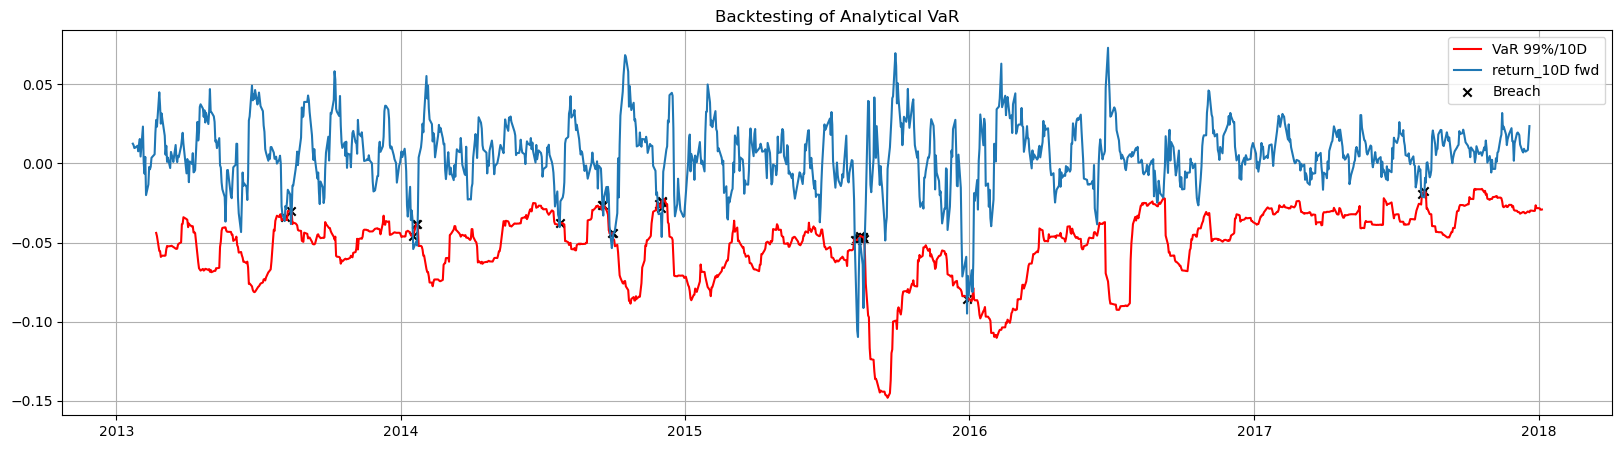

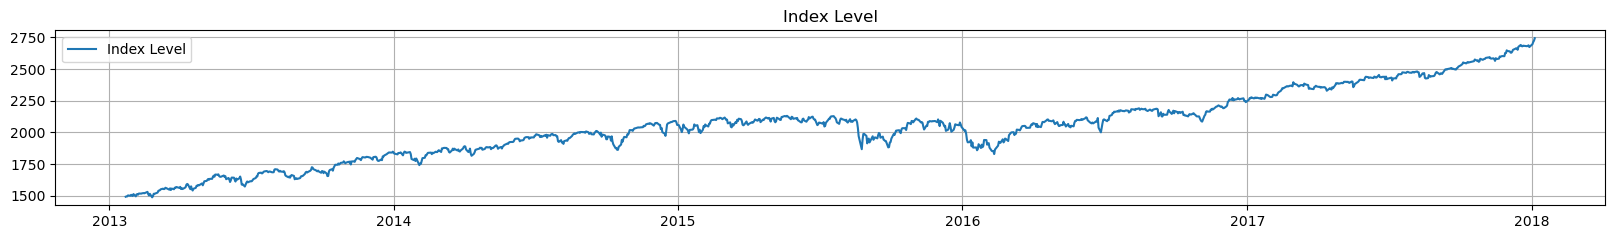

-   VaR_t plot starts after initial period -- as is expected.

-   data_breach.index keeps indexes (line numbers) the same as in
    original sample.

-   Alternative plot can be done using xl_eligible.index -- it will
    start about Day 21 position, where the VaR_t starts

------------------------------------------------------------------------

------------------------------------------------------------------------

## Cornish - Fisher Approximation for Empirical Percentile<a href="#Cornish---Fisher-Approximation-for-Empirical-Percentile" class="anchor-link">¶</a>

1.  In the Cornish-Fisher expansion, Skeweness \$S\$ and Kurtosis \$K\$
    are *parameters* that compute the percentile for a non-Normal random
    variable, which S&P 500 returns are empirically.

2.  The relationship between Skeweness, Kurtosis parameters and the
    sample skewness \$\\gamma_1\$ and the sample excess kurtosis
    \$\\gamma_2\$ of the historic log-returns is not of transform.
    Instead, \$\\gamma_1\$ and \$\\gamma_2\$ each is function of \$S,
    K\$. The system of two equations has to be solved by numerical
    optimisation. It is described in full in the Anatomy of
    Cornish-Fisher note.

3.  The above dillema has an easy solution: small values of actual
    skewness and kurtosis (\$\\gamma_1, \\gamma_2\$) roughly correspond
    to Skewness and Kurtosis parameters (S, K). However, there is an
    issue of validity domain: while S, K are parameters they have to
    have sensible values, eg sample skewness is not likely to be more
    than 2, and Skewness parameter is not likely to be much above
    0.5-0.7.

In \[ \]:

    skewness = data['LogReturn'].skew()

    # Pandas kurtosis method computes excess kurtosis, so no adjustment is needed
    excess_kurtosis = data['LogReturn'].kurtosis()

    print(f'Sample (actual) skewness of log-returns: {skewness}')
    print(f'Sample (actual) excess kurtosis of log-returns: {excess_kurtosis}')

    Sample (actual) skewness of log-returns: -0.436613594350232
    Sample (actual) excess kurtosis of log-returns: 2.8697267232088244

This is where our implementation is experimental and incomplete. We
pretend that these sample skewness and kurtosis are about the same as
parameters \$S,K\$.

In \[ \]:

    def cornish_fisher_percentile(p, skewness, excess_kurtosis):
        """
        Compute the Cornish-Fisher percentile based on skewness and excess kurtosis.
        
        - p: the probability for which to compute the percentile.
        - skewness
        - excess_kurtosis
        
        Returns:
        - The adjusted z-score (percentile) based on the Cornish-Fisher expansion.
        """
        # Standard normal quantile (z-score for the given probability)
        z = norm.ppf(p)
        
        # Cornish-Fisher expansion
        z_adj = z + (1/6)*(z**2 - 1)*skewness + (1/24)*(z**3 - 3*z)*excess_kurtosis - (1/36)*(2*z**3 - 5*z)*skewness**2
        
        return z_adj

In \[ \]:

    adjusted_percentile = cornish_fisher_percentile(1-c, skewness, excess_kurtosis)

    print(f'Adjusted percentile (z-score) for 1-c = {1-c}: {adjusted_percentile}')

    Adjusted percentile (z-score) for 1-c = 0.010000000000000009: -3.2465618105412624

In \[ \]:

    data['CF_VAR10D'] =  -0.5 * (data['STD'])**2 * 10 + adjusted_percentile * (data['STD']) * np.sqrt(10)

    data['CF_Breach'] = data['Ret10D'] <  data['CF_VAR10D']

    data_breach_cf = data[data['CF_Breach'] == True]

In \[ \]:

    # Filter for the eligible Number of comparisons
    data_eligible = data[pd.notnull(data['Ret10D']) & pd.notnull(data['VAR10D'])]

    # Filter for breaches
    data_breach = data[data['Breach'] == True]

                     S&P500  Unnamed: 2  LogReturn       STD    VAR10D    Ret10D  \
    Date                                                                           
    2013-01-22  1492.560059         NaN        NaN       NaN       NaN  0.012471   
    2013-01-23  1494.810059    0.001506   0.001506       NaN       NaN  0.011513   
    2013-01-24  1494.819946    0.000007   0.000007       NaN       NaN  0.009700   
    2013-01-25  1502.959961    0.005431   0.005431       NaN       NaN  0.009911   
    2013-01-28  1500.180054   -0.001851  -0.001851       NaN       NaN  0.011156   
    ...                 ...         ...        ...       ...       ...       ...   
    2017-12-29  2673.610107   -0.005197  -0.005197  0.003837 -0.028231       NaN   
    2018-01-02  2695.810059    0.008269   0.008269  0.003848 -0.028309       NaN   
    2018-01-03  2713.060059    0.006378   0.006378  0.003968 -0.029192       NaN   
    2018-01-04  2723.989990    0.004021   0.004021  0.003975 -0.029241       NaN   
    2018-01-05  2743.149902    0.007009   0.007009  0.003958 -0.029115       NaN   

                Breach  CF_VAR10D  CF_Breach  
    Date                                      
    2013-01-22   False        NaN      False  
    2013-01-23   False        NaN      False  
    2013-01-24   False        NaN      False  
    2013-01-25   False        NaN      False  
    2013-01-28   False        NaN      False  
    ...            ...        ...        ...  
    2017-12-29   False  -0.039471      False  
    2018-01-02   False  -0.039581      False  
    2018-01-03   False  -0.040818      False  
    2018-01-04   False  -0.040886      False  
    2018-01-05   False  -0.040710      False  

    [1250 rows x 9 columns]

In \[ \]:

    plt.title('Backtesting of Cornish-Fisher VaR');
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    #fig, ax = plt.subplots()
    #ax.set_xlim(0, 1009)

    varPlt, = plt.plot(data.index, data['CF_VAR10D'], color='RED');
    r10dplt, = plt.plot(data.index, data['Ret10D']);

    varBreachPlt = plt.scatter(data_breach_cf.index, data_breach_cf['CF_Breach'], color='BLACK', marker='x');

    plt.legend(["VaR 99%/10D","return_10D fwd","Breach"]);
    plt.grid();

    fig = plt.figure();
    ax1 = fig.add_subplot(211);
    ax1.set_title('Index Level');
    ax1.plot(data.index, data['S&P500'])
    ax1.legend(["Index Level"]);
    ax1.grid();
    plt.show();

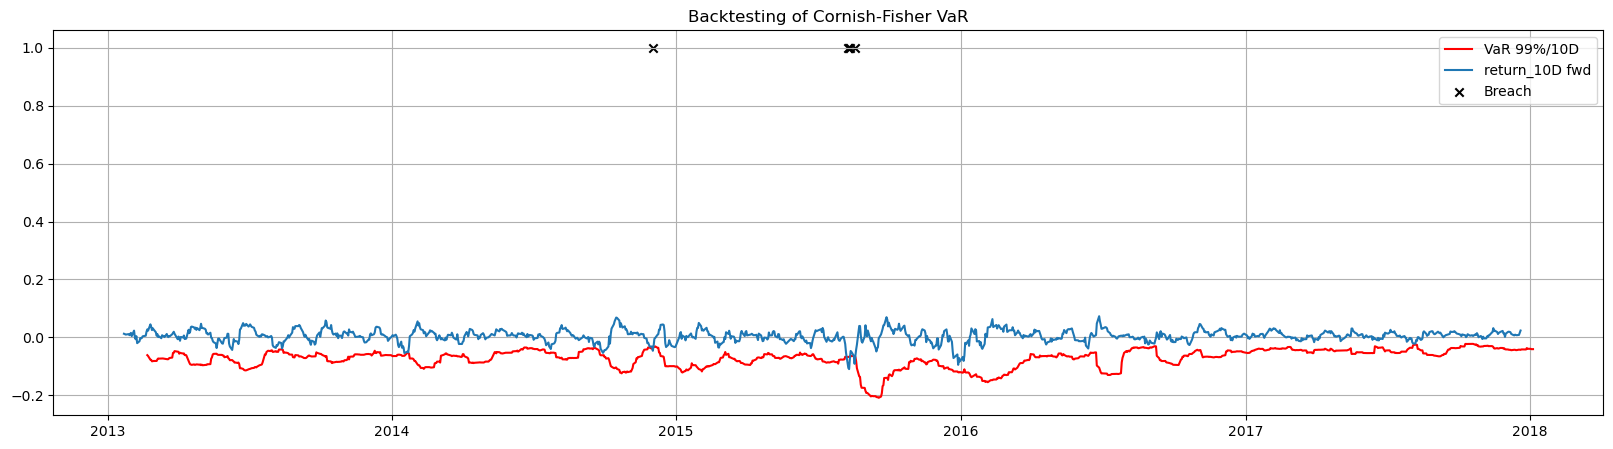

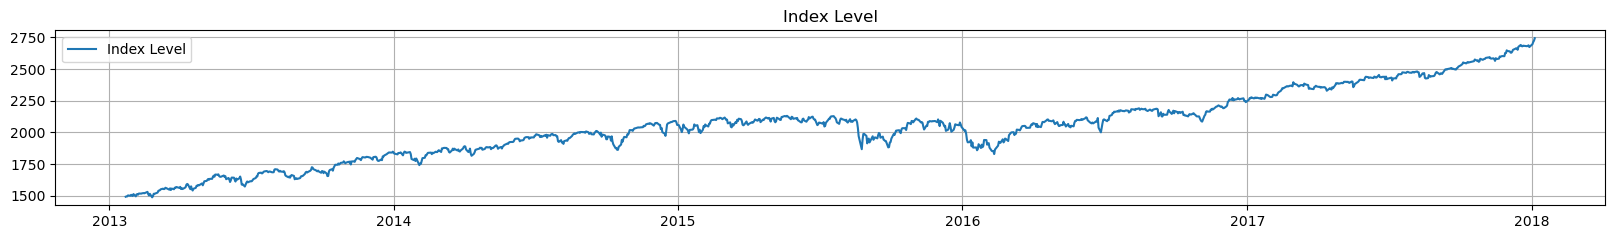

## Explore Skewness and Excess Kurtosis<a href="#Explore-Skewness-and-Excess-Kurtosis" class="anchor-link">¶</a>

In \[ \]:

    rolling_window = 42
    shift_period = 5

    # Compute rolling skewness
    xl['RollingSkewness'] = xl['LogReturn'].rolling(window=rolling_window, min_periods=rolling_window).skew()

    # Compute rolling kurtosis
    xl['RollingKurtosis'] = xl['LogReturn'].rolling(window=rolling_window, min_periods=rolling_window).kurt()

In \[ \]:

     

In \[ \]:

    # For plotting every 5th day from the rolling calculations
    selected_skewness = xl['RollingSkewness'][::shift_period]
    selected_kurtosis = xl['RollingKurtosis'][::shift_period]

In \[ \]:

    # Plotting
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(selected_skewness.index, selected_skewness)
    plt.title('Rolling Skewness (rolling window, shift period -- per code above)')
    plt.xlabel('Historic Obs')
    plt.ylabel('Skewness')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(selected_kurtosis.index, selected_kurtosis)
    plt.title('Rolling Kurtosis (rolling window, shift period -- per code above)')
    plt.xlabel('Historic Obs')
    plt.ylabel('Kurtosis')
    plt.legend()

    plt.tight_layout()
    plt.show()

    No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
    No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

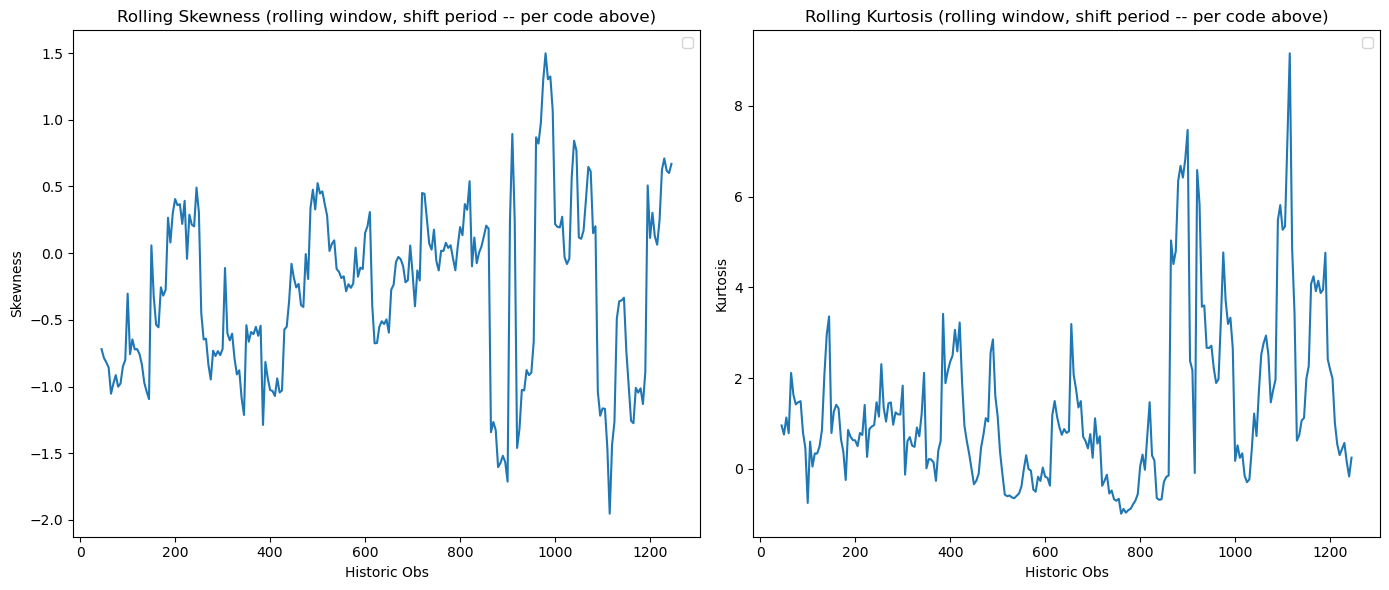

In \[ \]: